In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from scipy.spatial import cKDTree





In [2]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]

In [3]:
# Visually vetted GHOST results split up over 6 files
# So merge them, and take subset of just YSE DR1 objects

dfs = []
for idx in range(1, 7):
    df = pd.read_csv(f'../yse_ghost_hosts_before_vetting/{idx}_of_5/ghost_hosts.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
ps1_hosts_df = g_hosts_df.reset_index(drop=False)
ps1_hosts_df = ps1_hosts_df.set_index('TransientName')
ps1_hosts_df

,Unnamed: 0,level_0,index,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,...,NED_type,NED_vel,NED_redshift,NED_mag,class,dist/DLR,dist,TransientClass,TransientRA,TransientDEC
TransientName,,,,,,,,,,,,,,,,,,,,,
2017fgc,438,1083.0,1.0,PSO J012014.639+032412.408,NaN,NaN,NaN,112080200610004597,920640000012027,44345537343227,...,NaN,NaN,NaN,NaN,NaN,2.043633,3.864276,NaN,20.060167,3.402767
2019aaag,242,1587.0,13.0,PSO J122902.877+124305.856,NaN,NaN,NaN,123261872619862441,1075711000039539,102744207694452,...,G,NaN,NaN,19.8,False,0.042838,0.201594,NaN,187.262053,12.718327
2019aaax,96,632.0,20.0,PSO J101958.736-030625.511,NaN,NaN,NaN,104271549947461885,1044689000082043,378506877943937,...,G,NaN,NaN,21.8,False,0.015769,0.060278,NaN,154.994731,-3.107074
2019aabv,338,2275.0,39.0,PSO J095020.993+320144.032,NaN,NaN,NaN,146431475874425238,1055533000070586,214804199445433,...,*,NaN,NaN,20.1,False,0.058378,0.192407,NaN,147.587449,32.028943
2019aacg,66,431.0,43.0,PSO J104738.560-043456.602,NaN,NaN,NaN,102501619106751538,1050657000004462,379005094072685,...,IrS,NaN,NaN,NaN,False,0.111747,0.244734,NaN,161.910702,-4.582341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022cpk,462,2825.0,8244.0,PSO J091328.597+310703.441,NaN,NaN,NaN,145341383690751801,1048059000053667,214151364399522,...,NaN,NaN,NaN,NaN,NaN,1.665415,4.059217,NaN,138.370342,31.117122
2022gy,210,1680.0,8252.0,PSO J122727.536+081137.071,NaN,NaN,NaN,117831868647142827,1038671000072790,102894531583061,...,G,35795.0,0.119398,17.6,False,0.218665,2.091249,NaN,186.864439,8.194126
2022jq,130,1096.0,8270.0,PSO J091327.581+010010.966,NaN,NaN,NaN,109201383649304082,1011152000032043,58437325061418,...,G,NaN,NaN,18.8,False,0.343289,1.654076,NaN,138.365050,1.003510


explanation of PS1 features (not custom GHOST ones): 

https://outerspace.stsci.edu/display/PANSTARRS/PS1+Database+object+and+detection+tables 

In [4]:
# explanation of PS1 features (not custom GHOST ones): 
# https://outerspace.stsci.edu/display/PANSTARRS/PS1+Database+object+and+detection+tables 

feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
#  'zPSFFluxErr',
 'zApFlux',
#  'zApFluxErr',
#  'zApFillFac',
#  'zApRadius',
 'zKronFlux',
#  'zKronFluxErr',
 'zKronRad',
#  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
#   'yPSFFluxErr',
  'yApFlux',
#   'yApFluxErr',
#   'yApFillFac',
#  'yApRadius',
 'yKronFlux',
#  'yKronFluxErr',
 'yKronRad',
#  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

In [5]:
# only keep features of bank
host_dataset_bank = ps1_hosts_df[feature_names_hostgal]
        
# drop row if any feature values are nan
host_dataset_bank = host_dataset_bank[~host_dataset_bank[feature_names_hostgal].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
host_dataset_bank

,gmomentXX,gmomentXY,gmomentYY,gmomentR1,gmomentRH,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
TransientName,,,,,,,,,,,,,,,,,,,,,
2019aaag,0.322234,0.003140,0.299576,1.616320,1.034360,0.000024,0.000042,0.000045,4.04080,12.911300,...,4.27831,13.846000,0.277901,0.080601,0.140699,0.269800,0.248400,0.201000,25.881954,0.042838
2019aaax,0.189772,-0.004596,0.198261,1.141030,0.849408,0.000030,0.000035,0.000033,2.85257,2.607320,...,2.78548,8.117690,0.336901,-0.051600,0.044199,0.081400,0.188400,-0.030800,45.987305,0.015769
2019aabv,0.283302,-0.002636,0.257574,1.130610,0.885985,0.000026,0.000028,0.000027,2.82652,2.351040,...,2.71481,3.608620,0.445200,-0.066900,-0.054901,-0.008900,-0.004499,-0.130301,70.602938,0.058378
2019aacg,0.193669,0.035234,0.161559,0.843921,0.666147,0.000005,0.000004,0.000004,2.10980,-1.447330,...,2.23357,2.534030,-0.267500,0.147301,-0.125401,-0.035101,-0.128801,-0.098099,42.370442,0.111747
2019aacp,0.327138,0.013750,0.297035,1.360040,0.904056,0.000010,0.000015,0.000015,3.40009,7.569170,...,2.95051,9.019760,0.431900,0.000399,0.025101,0.081900,0.022999,0.049299,9.815558,0.060816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022cnt,0.326595,0.010935,0.345536,2.178740,1.169140,0.000067,0.000183,0.000242,5.44686,34.122898,...,4.98550,21.261999,0.067699,0.299900,0.225000,0.287399,0.394600,0.274000,23.342873,0.337622
2022cpj,0.249317,0.004646,0.267804,1.386830,0.984514,0.000037,0.000062,0.000061,3.46707,13.196400,...,3.01631,13.647900,0.105900,-0.007299,-0.013500,0.022099,0.037600,-0.051899,16.364097,0.063465
2022gy,0.382634,0.011327,0.331931,3.645380,1.195170,0.000055,0.000124,0.000284,9.11345,27.451300,...,7.61617,20.641300,0.190599,0.900299,0.815701,0.880999,0.775600,0.697001,28.305594,0.218665


In [8]:
#host_dataset_bank.loc['2019wqf']

gmomentXX            0.396253
gmomentXY           -0.061127
gmomentYY            0.389319
gmomentR1            6.443670
gmomentRH            1.232190
gPSFFlux             0.000159
gApFlux              0.000414
gKronFlux            0.001461
gKronRad            16.109200
gExtNSigma          25.573999
rmomentXX            0.288287
rmomentXY           -0.041989
rmomentYY            0.285553
rmomentR1            7.588350
rmomentRH            1.137360
rPSFFlux             0.000293
rApFlux              0.000746
rKronFlux            0.003025
rKronRad            18.970900
rExtNSigma          28.197399
imomentXX            0.269603
imomentXY           -0.039880
imomentYY            0.267439
imomentR1            7.921140
imomentRH            1.116860
iPSFFlux             0.000430
iApFlux              0.001032
iKronFlux            0.004360
iKronRad            19.802900
iExtNSigma          28.332199
zmomentXX            0.222607
zmomentXY           -0.032673
zmomentYY            0.214704
zmomentR1 

In [9]:
host_dataset_bank.columns.to_list()

['gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
 'gApFlux',
 'gKronFlux',
 'gKronRad',
 'gExtNSigma',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
 'rPSFFlux',
 'rApFlux',
 'rKronFlux',
 'rKronRad',
 'rExtNSigma',
 'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
 'iApFlux',
 'iKronFlux',
 'iKronRad',
 'iExtNSigma',
 'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
 'zApFlux',
 'zKronFlux',
 'zKronRad',
 'zExtNSigma',
 'ymomentXX',
 'ymomentXY',
 'ymomentYY',
 'ymomentR1',
 'ymomentRH',
 'yPSFFlux',
 'yApFlux',
 'yKronFlux',
 'yKronRad',
 'yExtNSigma',
 'i-z',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD',
 'dist/DLR']

In [10]:
# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(host_dataset_bank.index, dtype='object'))
feat_arr = np.vstack(np.array(host_dataset_bank, dtype='object'))

scaler = preprocessing.StandardScaler() # Create a scalar
#scaler = preprocessing.MinMaxScaler() # Create a scalar
scaler.fit(feat_arr) # Fit only to training data
feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()


In [11]:
# Reference

#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2019pmd'] # SN Ia, in spiral (medium size), matches all Ia in z=0.02 to z=0.06. Most spiral
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021qxr'] # SN Ia, bright elliptical
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021smj'] # SN Ia, bright spiral
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021dbg'] # SN II, bright spiral
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021qht'] # no spec class, bright spiral, edge on
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021sev'] # SN II, smudgy top down gal (good matches)
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021xbg'] # SN Ibc, spiral on edge pointing down (first match is good, rest not as much)
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021aadc'] # SLSN-II, small smudgy host (good matches)

dataset_ref = host_dataset_bank[host_dataset_bank.index == '2020nvb'] # SN Ia, in bright spiral, near core ish, z=0.002939

dataset_ref 

,gmomentXX,gmomentXY,gmomentYY,gmomentR1,gmomentRH,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
TransientName,,,,,,,,,,,,,,,,,,,,,
2020nvb,0.465099,-0.018149,0.440623,7.60057,1.27996,0.007361,0.018106,0.052791,19.0014,22.6656,...,26.6637,31.365499,0.2549,1.161799,1.4029,1.7577,1.784699,1.7463,831.67671,0.586238


In [12]:
#dataset_ref.columns.to_list()

In [13]:
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))

#scaler.fit(feat_arr_ref) # Fit only to training data
scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

ZTF ID name (ref) 2020nvb


https://ziggy.ucolick.org/yse/transient_detail/2020nvb

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2020nvb

0		603				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2020mza

1		565				None			114.0616


https://ziggy.ucolick.org/yse/transient_detail/2021pkz

2		1627				None			126.6436


https://ziggy.ucolick.org/yse/transient_detail/2020abim

3		93				None			127.7518


https://ziggy.ucolick.org/yse/transient_detail/2021bbz

4		1259				None			128.2801


https://ziggy.ucolick.org/yse/transient_detail/2020ghq

5		317				None			129.7536


https://ziggy.ucolick.org/yse/transient_detail/2020dxa

6		278				None			130.8306


https://ziggy.ucolick.org/yse/transient_detail/2020nrg

7		595				None			131.0658


https://ziggy.ucolick.org/yse/transient_detail/2020ulf

8		862				None			131.2581


https://ziggy.ucolick.org/yse/transient_detail/2021lxb

9		1537				None			132.4831


# TODO: do ANN for all matches, find the 1st ANN with largest d from its reference.

In [14]:
ref_name_l, id_l, dist_l = [], [], []
for ref in list(host_dataset_bank.index):
    dataset_ref = host_dataset_bank[host_dataset_bank.index == ref] 
    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))

    #scaler.fit(feat_arr_ref) # Fit only to training data
    scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')
ann_dist_all_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,dist=0,dist=1,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9
key_0,,,,,,,,,,,,,,,,,,,,
2019aaag,0,257,1617,289,1184,894,292,471,258,1167,0.0,1.623055,2.018886,2.275835,2.347722,2.498713,2.659881,2.675755,2.682098,2.703773
2019aaax,1,1241,50,1717,1483,616,1658,49,1263,2,0.0,1.935321,2.137677,2.189499,2.263004,2.274283,2.356216,2.470910,2.481375,2.500894
2019aabv,2,962,676,49,4,828,1,1717,744,1231,0.0,2.020136,2.267684,2.308610,2.323211,2.384822,2.500894,2.500916,2.520159,2.528947
2019aacg,3,153,444,1787,67,739,1421,1821,1732,1190,0.0,4.106795,4.165354,4.287402,4.297078,4.299583,4.378145,4.410028,4.423481,4.491932
2019aacp,4,828,937,2,901,49,988,1231,50,1156,0.0,2.299376,2.318427,2.323211,2.373232,2.374547,2.379968,2.381772,2.415555,2.488260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022cnt,1942,1945,1510,538,41,47,1381,171,159,1547,0.0,2.549641,2.619030,2.644939,2.738010,2.903155,2.906580,2.944473,2.982031,3.048135
2022cpj,1943,442,405,833,411,1057,392,367,1131,1594,0.0,1.626839,1.724802,1.931214,1.988296,2.080904,2.089209,2.098497,2.114715,2.125731
2022gy,1944,1304,1608,228,963,1901,171,1670,1628,1726,0.0,3.253908,3.302190,3.309568,3.343692,3.369853,3.399214,3.589022,3.647241,3.665174


In [15]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df['dist=1']))
print("Scatter median:", np.median(ann_dist_all_df['dist=1']))
print("Scatter std:", np.std(ann_dist_all_df['dist=1']))
print("Scatter max:", np.max(ann_dist_all_df['dist=1']))
print("Scatter min:", np.min(ann_dist_all_df['dist=1']))
print("\n")


# Returns index of max distance
print("Most anomalous (max distance of ref to ANN=1):", ann_dist_all_df[['dist=1']].idxmax().values[0])

summary stats
Scatter mean: 2.9190279502224543
Scatter median: 2.656944990158081
Scatter std: 2.8230442537951506
Scatter max: 114.06158447265625
Scatter min: 0.0


Most anomalous (max distance of ref to ANN=1): 2020nvb


In [16]:
ref_obj = '2020nvb'
print("Dist=1:", ann_dist_all_df.loc[ref_obj]['dist=1']) # Kron, Ap, and PSF fluxes are too high

Dist=1: 114.06158447265625


In [17]:
host_dataset_bank[host_dataset_bank.index == ref_obj]

,gmomentXX,gmomentXY,gmomentYY,gmomentR1,gmomentRH,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
TransientName,,,,,,,,,,,,,,,,,,,,,
2020nvb,0.465099,-0.018149,0.440623,7.60057,1.27996,0.007361,0.018106,0.052791,19.0014,22.6656,...,26.6637,31.365499,0.2549,1.161799,1.4029,1.7577,1.784699,1.7463,831.67671,0.586238


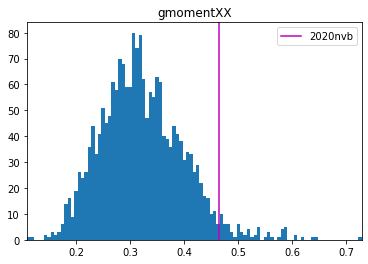

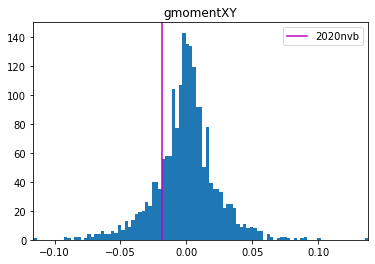

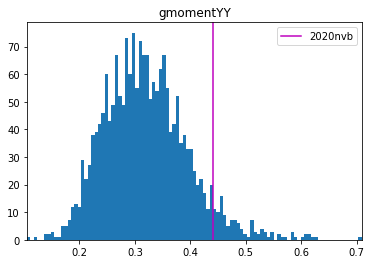

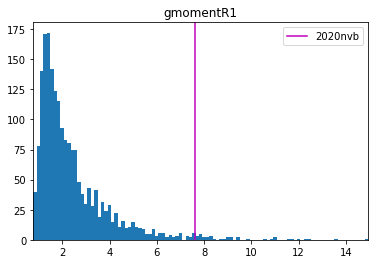

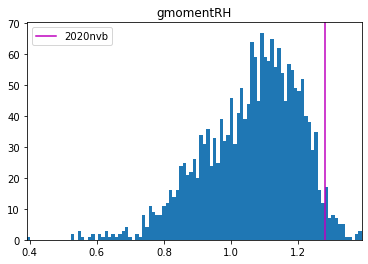

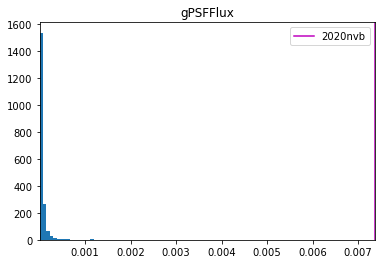

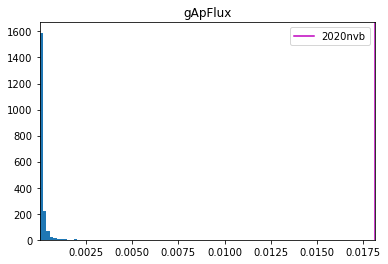

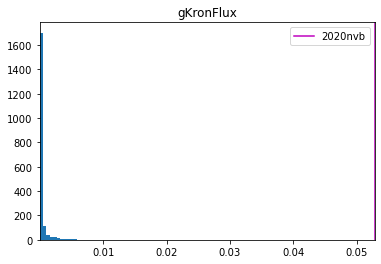

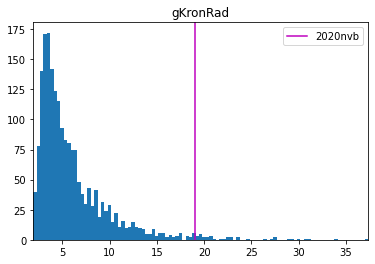

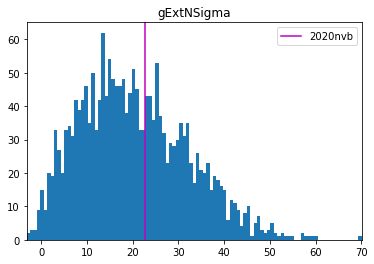

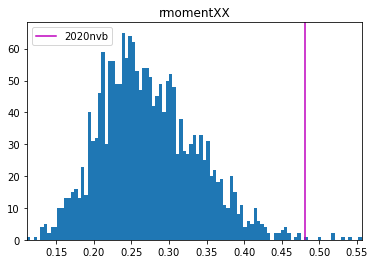

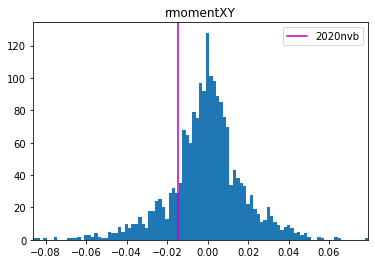

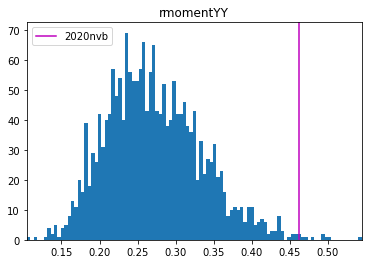

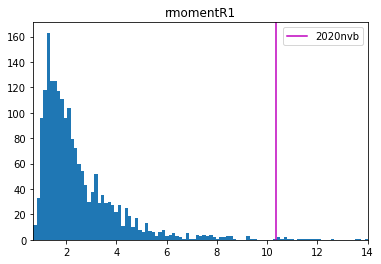

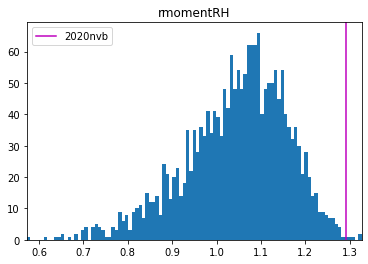

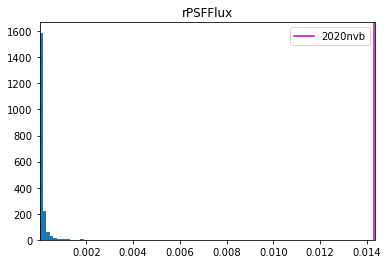

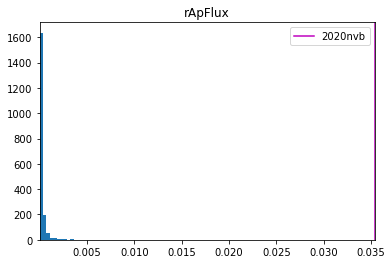

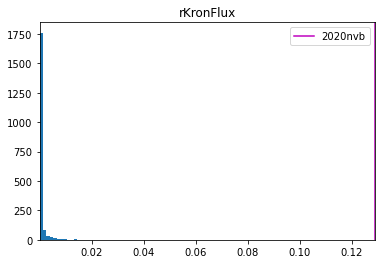

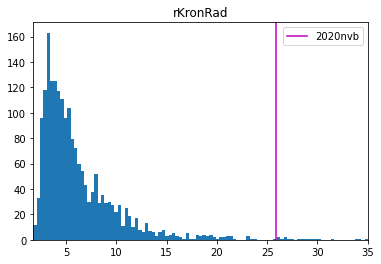

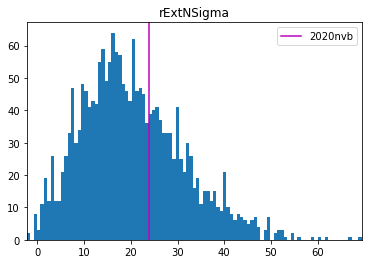

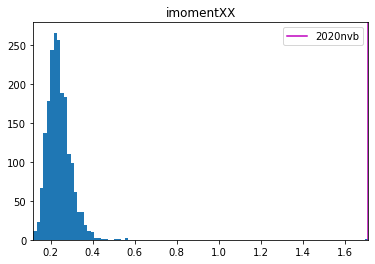

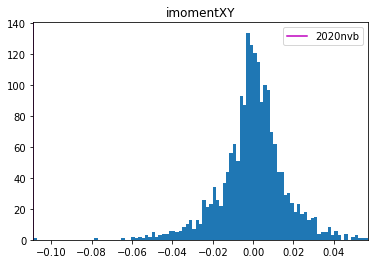

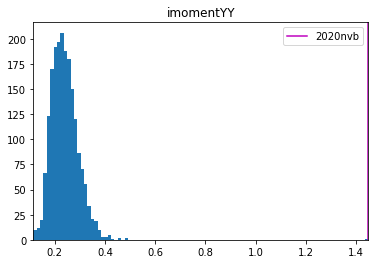

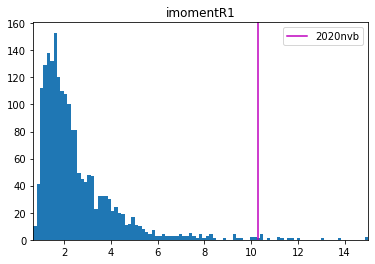

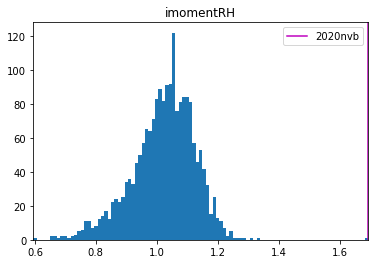

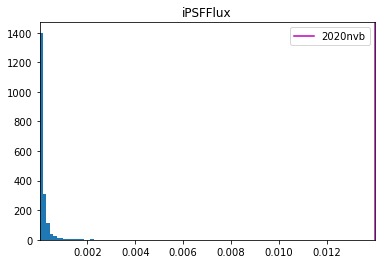

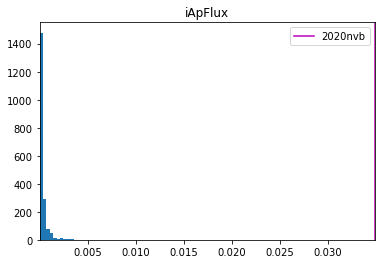

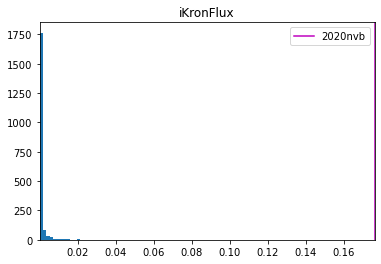

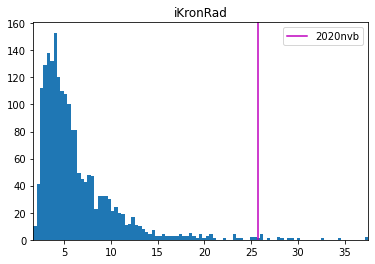

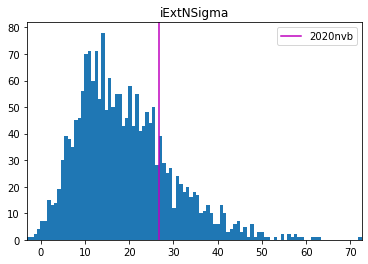

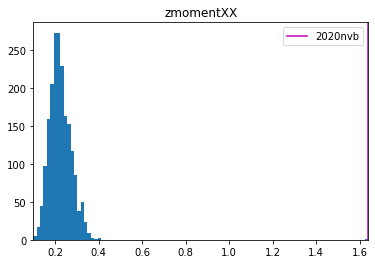

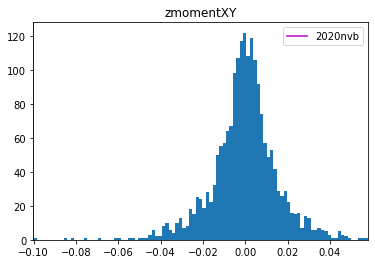

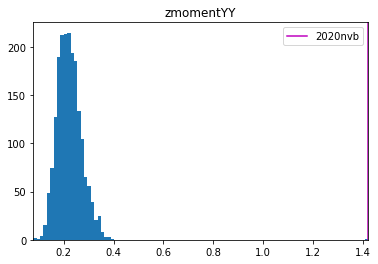

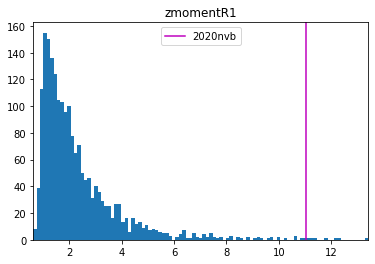

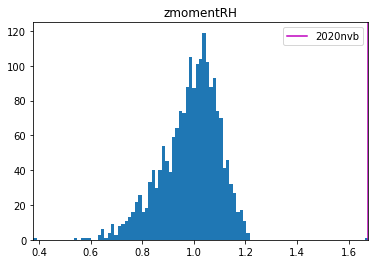

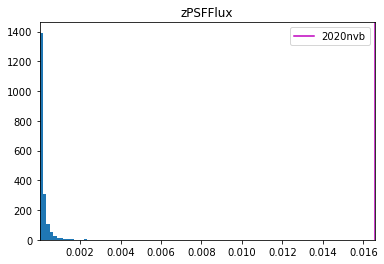

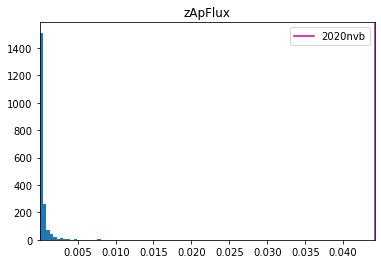

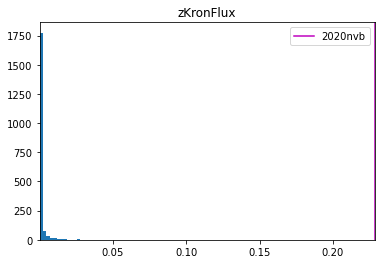

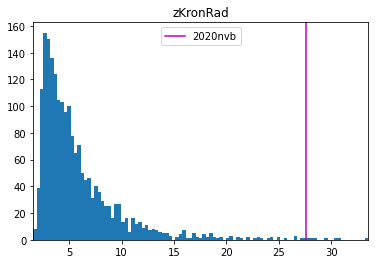

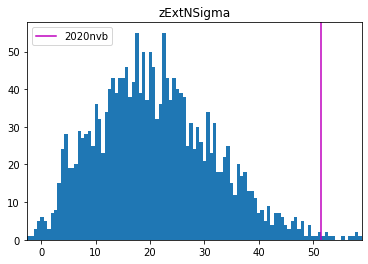

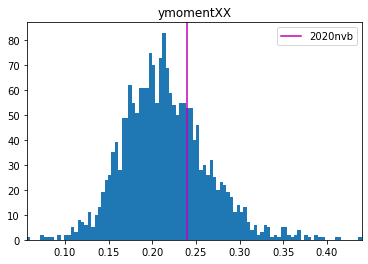

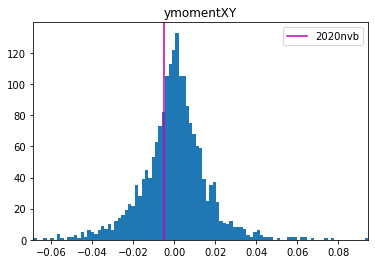

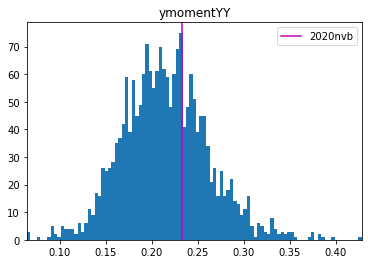

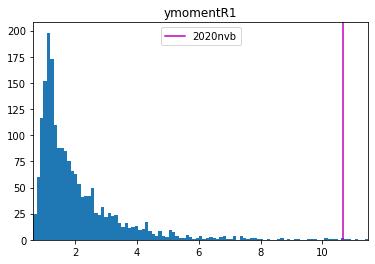

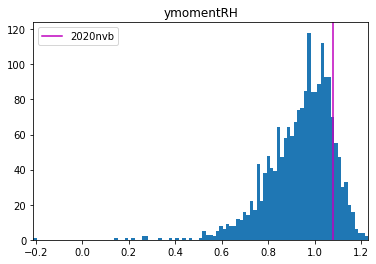

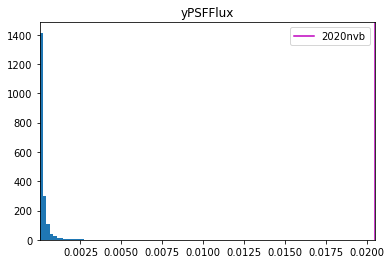

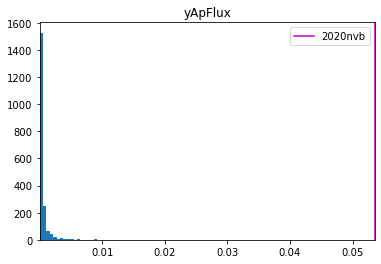

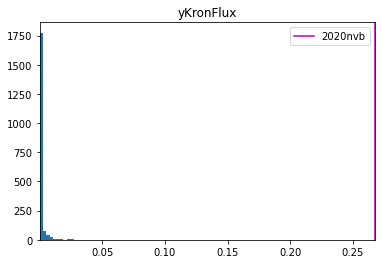

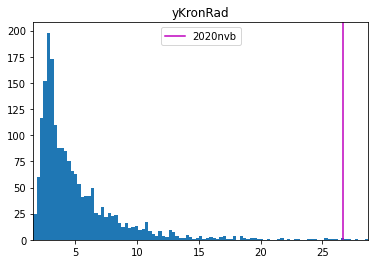

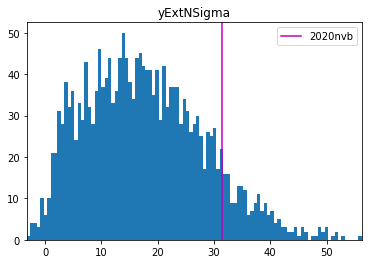

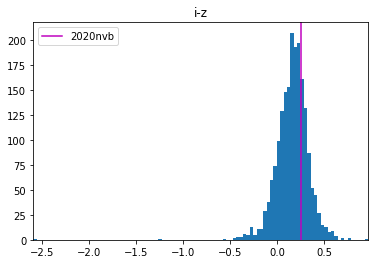

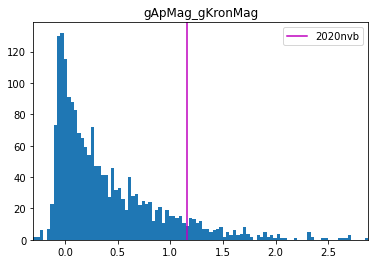

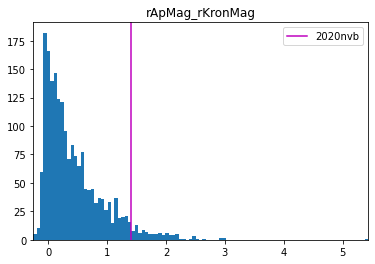

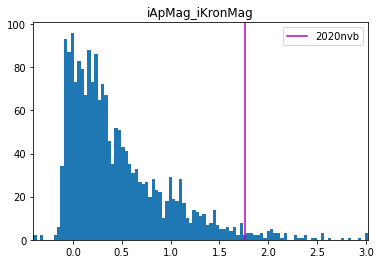

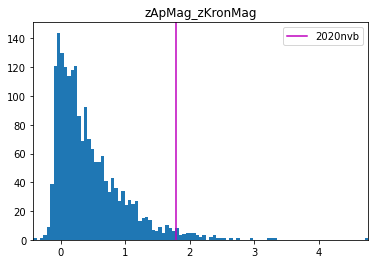

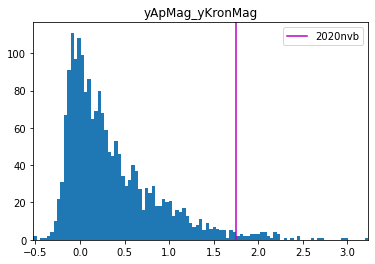

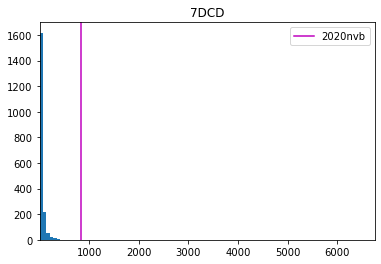

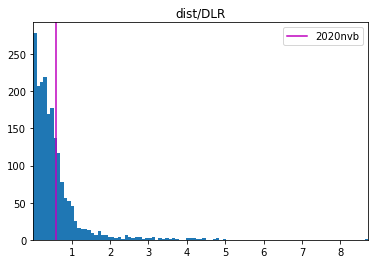

In [18]:
feat_scatter_l = []
for feat in host_dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(host_dataset_bank[feat]), np.max(host_dataset_bank[feat])
    
    ax.hist(host_dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = host_dataset_bank[host_dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(host_dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [19]:
# Five largest ANN=1 distances
ann_dist_all_df['dist=1'].nlargest(5)

key_0
2020nvb    114.061584
2021kni     27.051531
2021ukf     17.728050
2020mza     16.747040
2020bcq     15.331490
Name: dist=1, dtype: float64

In [20]:
dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021kni']
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))

#scaler.fit(feat_arr_ref) # Fit only to training data
scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

ZTF ID name (ref) 2021kni


https://ziggy.ucolick.org/yse/transient_detail/2021kni

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2021kni

0		1489				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2021ukf

1		1788				None			27.0515


https://ziggy.ucolick.org/yse/transient_detail/2021qzi

2		1692				None			32.7691


https://ziggy.ucolick.org/yse/transient_detail/2020aeqm

3		209				None			33.2193


https://ziggy.ucolick.org/yse/transient_detail/2021sve

4		1756				None			33.7023


https://ziggy.ucolick.org/yse/transient_detail/2021gyh

5		1387				None			34.0573


https://ziggy.ucolick.org/yse/transient_detail/2020onu

6		626				None			34.0686


https://ziggy.ucolick.org/yse/transient_detail/2020igy

7		353				None			34.2438


https://ziggy.ucolick.org/yse/transient_detail/2021sje

8		1736				None			34.3779


https://ziggy.ucolick.org/yse/transient_detail/2020azh

9		246				None			34.479


# YSE DR1 lc features and host info

In [21]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]

In [22]:
archive = np.load("../features/yse_dr1_zenodo.npz")
ids = archive["ids"]  # object names
features = archive["features"]  # 2d array, objects x features 
# Convert to record arrays with feature names:
with open("../features/names.txt") as fh:
    names = fh.read().split()
features = np.rec.array(features, names=names, formats=["f"] * len(names)).squeeze()

In [23]:
dr1_lc_allfeat_df = pd.DataFrame(features, columns=names)
dr1_lc_allfeat_df = dr1_lc_allfeat_df.set_index(ids)
dr1_lc_allfeat_df.sort_index(inplace=True)
dr1_lc_allfeat_df

,mag_anderson_darling_normal_g,mag_bins_window1.0_offset0.0_beyond_1_std_g,mag_bins_window1.0_offset0.0_beyond_2_std_g,mag_bins_window1.0_offset0.0_eta_e_g,mag_bins_window1.0_offset0.0_kurtosis_g,mag_bins_window1.0_offset0.0_linear_trend_g,mag_bins_window1.0_offset0.0_linear_trend_sigma_g,mag_bins_window1.0_offset0.0_linear_trend_noise_g,mag_bins_window1.0_offset0.0_maximum_slope_g,mag_bins_window1.0_offset0.0_minimum_time_interval_g,...,fullflux_bazin_fit_fall_time_Y,fullflux_bazin_fit_reduced_chi2_Y,fullflux_villar_fit_amplitude_Y,fullflux_villar_fit_baseline_Y,fullflux_villar_fit_reference_time_Y,fullflux_villar_fit_rise_time_Y,fullflux_villar_fit_fall_time_Y,fullflux_villar_fit_plateau_rel_amplitude_Y,fullflux_villar_fit_plateau_duration_Y,fullflux_villar_fit_reduced_chi2_Y
2019lbi,0.216406,0.444444,0.0,10.290580,-1.233801,0.007288,0.001786,0.242701,0.209614,3.0,...,85.686859,2.423075,9208.376953,-92.017288,-1195.647583,83.931435,94.492111,0.288869,4.881969,1.047435
2019pmd,0.391645,0.285714,0.0,1.806227,-0.705101,0.011165,0.002437,0.129676,0.078864,3.0,...,23.487520,6.380569,32643.027344,305.142731,-1265.290039,3.740786,27.303635,0.766776,38.719402,5.219153
2019ppi,NaN,0.000000,0.0,2.000000,NaN,NaN,NaN,NaN,0.082812,9.0,...,21.816778,3.437780,4157.710449,230.103683,-1201.411377,49.079441,56.896420,0.799803,28.853926,2.696669
2019szh,NaN,0.000000,0.0,2.000000,NaN,NaN,NaN,NaN,0.092147,6.0,...,24.085527,3.861329,4443.414062,179.280121,-1264.499390,13.052733,23.961723,0.004652,41.019459,13.561466
2019tvv,NaN,0.333333,0.0,27.854954,NaN,0.003921,0.004322,0.219535,0.047642,6.0,...,22.693514,4.903403,48788.632812,167.568161,-1209.337646,8.856142,30.131523,0.790199,11.299833,2.127344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021ztz,0.253991,0.250000,0.0,0.422869,3.625412,0.062985,0.011643,0.130696,0.086599,3.0,...,17.565086,1.424005,1643.183716,115.727654,-523.097534,3.430753,19.209139,0.029427,11.852758,1.670255
2021zuf,NaN,0.000000,0.0,2.000000,NaN,NaN,NaN,NaN,0.001574,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021zvo,NaN,0.333333,0.0,5.862638,NaN,-0.029232,0.009775,0.200013,0.111863,2.0,...,21.983507,0.461530,1485.035889,-240.269516,-553.913696,5.401869,86654.609375,0.595883,35.150803,0.548194
2021zvx,NaN,0.333333,0.0,1.354845,NaN,0.008765,0.006001,0.064070,0.016849,6.0,...,30.308945,4.260723,492.952515,220.026062,-523.277039,3.950231,17.788208,0.000314,13.657744,0.278923


In [24]:
dr1_lc_allfeat_df.columns.to_list()

['mag_anderson_darling_normal_g',
 'mag_bins_window1.0_offset0.0_beyond_1_std_g',
 'mag_bins_window1.0_offset0.0_beyond_2_std_g',
 'mag_bins_window1.0_offset0.0_eta_e_g',
 'mag_bins_window1.0_offset0.0_kurtosis_g',
 'mag_bins_window1.0_offset0.0_linear_trend_g',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_g',
 'mag_bins_window1.0_offset0.0_linear_trend_noise_g',
 'mag_bins_window1.0_offset0.0_maximum_slope_g',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_g',
 'mag_bins_window1.0_offset0.0_observation_count_g',
 'mag_bins_window1.0_offset0.0_skew_g',
 'mag_duration_g',
 'mag_inter_percentile_range_1_g',
 'mag_linear_fit_slope_g',
 'mag_linear_fit_slope_sigma_g',
 'mag_linear_fit_reduced_chi2_g',
 'mag_maximum_time_interval_g',
 'mag_observation_count_g',
 'mag_period_0_g',
 'mag_period_s_to_n_0_g',
 'mag_periodogram_median_g',
 'mag_periodogram_percent_difference_magnitude_percentile_25_g',
 'mag_chi2_g',
 'mag_stetson_K_g',
 'mag_weighted_mean_g',
 'mag_anderson_darling_n

In [25]:
lc_feature_names = [
#  'mag_anderson_darling_normal_g',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_g',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_g',
# #  'mag_bins_window1.0_offset0.0_eta_e_g',
#  'mag_bins_window1.0_offset0.0_kurtosis_g',
#  'mag_bins_window1.0_offset0.0_linear_trend_g',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_g',
# #  'mag_bins_window1.0_offset0.0_linear_trend_noise_g',
#  'mag_bins_window1.0_offset0.0_maximum_slope_g',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_g',
#  'mag_bins_window1.0_offset0.0_observation_count_g',
#  'mag_bins_window1.0_offset0.0_skew_g',
#  'mag_duration_g',
#  'mag_inter_percentile_range_1_g',
# #  'mag_linear_fit_slope_g',
# #  'mag_linear_fit_slope_sigma_g',
# #  'mag_linear_fit_reduced_chi2_g',
# #  'mag_maximum_time_interval_g',
# #  'mag_observation_count_g',
# #  'mag_period_0_g',
#  'mag_period_s_to_n_0_g',
# #  'mag_periodogram_median_g',
# #  'mag_periodogram_percent_difference_magnitude_percentile_25_g',
# #  'mag_chi2_g',
#  'mag_stetson_K_g',
#  'mag_weighted_mean_g',
#  'mag_anderson_darling_normal_r',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_r',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_r',
# #  'mag_bins_window1.0_offset0.0_eta_e_r',
#  'mag_bins_window1.0_offset0.0_kurtosis_r',
#  'mag_bins_window1.0_offset0.0_linear_trend_r',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_r',
# #  'mag_bins_window1.0_offset0.0_linear_trend_noise_r',
#  'mag_bins_window1.0_offset0.0_maximum_slope_r',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_r',
#  'mag_bins_window1.0_offset0.0_observation_count_r',
#  'mag_bins_window1.0_offset0.0_skew_r',
#  'mag_duration_r',
#  'mag_inter_percentile_range_1_r',
# #  'mag_linear_fit_slope_r',
# #  'mag_linear_fit_slope_sigma_r',
# #  'mag_linear_fit_reduced_chi2_r',
# #  'mag_maximum_time_interval_r',
# #  'mag_observation_count_r',
# #  'mag_period_0_r',
#  'mag_period_s_to_n_0_r',
#  'mag_periodogram_median_r',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_r',
#  'mag_chi2_r',
#  'mag_stetson_K_r',
#  'mag_weighted_mean_r',
#  'mag_anderson_darling_normal_i',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_i',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_i',
#  'mag_bins_window1.0_offset0.0_eta_e_i',
#  'mag_bins_window1.0_offset0.0_kurtosis_i',
#  'mag_bins_window1.0_offset0.0_linear_trend_i',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_i',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_i',
#  'mag_bins_window1.0_offset0.0_maximum_slope_i',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_i',
#  'mag_bins_window1.0_offset0.0_observation_count_i',
#  'mag_bins_window1.0_offset0.0_skew_i',
#  'mag_duration_i',
#  'mag_inter_percentile_range_1_i',
#  'mag_linear_fit_slope_i',
#  'mag_linear_fit_slope_sigma_i',
#  'mag_linear_fit_reduced_chi2_i',
#  'mag_maximum_time_interval_i',
#  'mag_observation_count_i',
#  'mag_period_0_i',
#  'mag_period_s_to_n_0_i',
#  'mag_periodogram_median_i',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_i',
#  'mag_chi2_i',
#  'mag_stetson_K_i',
#  'mag_weighted_mean_i',
#  'mag_anderson_darling_normal_z',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_z',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_z',
#  'mag_bins_window1.0_offset0.0_eta_e_z',
#  'mag_bins_window1.0_offset0.0_kurtosis_z',
#  'mag_bins_window1.0_offset0.0_linear_trend_z',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_z',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_z',
#  'mag_bins_window1.0_offset0.0_maximum_slope_z',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_z',
#  'mag_bins_window1.0_offset0.0_observation_count_z',
#  'mag_bins_window1.0_offset0.0_skew_z',
#  'mag_duration_z',
#  'mag_inter_percentile_range_1_z',
#  'mag_linear_fit_slope_z',
#  'mag_linear_fit_slope_sigma_z',
#  'mag_linear_fit_reduced_chi2_z',
#  'mag_maximum_time_interval_z',
#  'mag_observation_count_z',
#  'mag_period_0_z',
#  'mag_period_s_to_n_0_z',
#  'mag_periodogram_median_z',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_z',
#  'mag_chi2_z',
#  'mag_stetson_K_z',
#  'mag_weighted_mean_z',
 'mag_anderson_darling_normal_X',
 'mag_bins_window1.0_offset0.0_beyond_1_std_X',
 'mag_bins_window1.0_offset0.0_beyond_2_std_X',
#  'mag_bins_window1.0_offset0.0_eta_e_X',
 'mag_bins_window1.0_offset0.0_kurtosis_X',
 'mag_bins_window1.0_offset0.0_linear_trend_X',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_X',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_X',
 'mag_bins_window1.0_offset0.0_maximum_slope_X',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_X',
 'mag_bins_window1.0_offset0.0_observation_count_X',
 'mag_bins_window1.0_offset0.0_skew_X',
 'mag_duration_X',
 'mag_inter_percentile_range_1_X',
#  'mag_linear_fit_slope_X',
#  'mag_linear_fit_slope_sigma_X',
#  'mag_linear_fit_reduced_chi2_X',
#  'mag_maximum_time_interval_X',
#  'mag_observation_count_X',
#  'mag_period_0_X',
 'mag_period_s_to_n_0_X',
#  'mag_periodogram_median_X',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_X',
#  'mag_chi2_X',
 'mag_stetson_K_X',
 'mag_weighted_mean_X',
 'mag_anderson_darling_normal_Y',
 'mag_bins_window1.0_offset0.0_beyond_1_std_Y',
 'mag_bins_window1.0_offset0.0_beyond_2_std_Y',
#  'mag_bins_window1.0_offset0.0_eta_e_Y',
 'mag_bins_window1.0_offset0.0_kurtosis_Y',
 'mag_bins_window1.0_offset0.0_linear_trend_Y',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_Y',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_Y',
 'mag_bins_window1.0_offset0.0_maximum_slope_Y',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_Y',
 'mag_bins_window1.0_offset0.0_observation_count_Y',
 'mag_bins_window1.0_offset0.0_skew_Y',
 'mag_duration_Y',
 'mag_inter_percentile_range_1_Y',
#  'mag_linear_fit_slope_Y',
#  'mag_linear_fit_slope_sigma_Y',
#  'mag_linear_fit_reduced_chi2_Y',
#  'mag_maximum_time_interval_Y',
#  'mag_observation_count_Y',
#  'mag_period_0_Y',
 'mag_period_s_to_n_0_Y',
#  'mag_periodogram_median_Y',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_Y',
#  'mag_chi2_Y',
 'mag_stetson_K_Y',
 'mag_weighted_mean_Y',
#  'flux_kurtosis_g',
#  'flux_skew_g',
#  'flux_kurtosis_r',
#  'flux_skew_r',
#  'flux_kurtosis_i',
#  'flux_skew_i',
#  'flux_kurtosis_z',
#  'flux_skew_z',
#  'flux_kurtosis_X',
#  'flux_skew_X',
#  'flux_kurtosis_Y',
#  'flux_skew_Y',
#  'fullflux_bazin_fit_amplitude_g',
#  'fullflux_bazin_fit_baseline_g',
#  'fullflux_bazin_fit_reference_time_g',
#  'fullflux_bazin_fit_rise_time_g',
#  'fullflux_bazin_fit_fall_time_g',
#  'fullflux_bazin_fit_reduced_chi2_g',
#  'fullflux_villar_fit_amplitude_g',
#  'fullflux_villar_fit_baseline_g',
#  'fullflux_villar_fit_reference_time_g',
#  'fullflux_villar_fit_rise_time_g',
#  'fullflux_villar_fit_fall_time_g',
#  'fullflux_villar_fit_plateau_rel_amplitude_g',
#  'fullflux_villar_fit_plateau_duration_g',
#  'fullflux_villar_fit_reduced_chi2_g',
#  'fullflux_bazin_fit_amplitude_r',
#  'fullflux_bazin_fit_baseline_r',
#  'fullflux_bazin_fit_reference_time_r',
#  'fullflux_bazin_fit_rise_time_r',
#  'fullflux_bazin_fit_fall_time_r',
#  'fullflux_bazin_fit_reduced_chi2_r',
#  'fullflux_villar_fit_amplitude_r',
#  'fullflux_villar_fit_baseline_r',
#  'fullflux_villar_fit_reference_time_r',
#  'fullflux_villar_fit_rise_time_r',
#  'fullflux_villar_fit_fall_time_r',
#  'fullflux_villar_fit_plateau_rel_amplitude_r',
#  'fullflux_villar_fit_plateau_duration_r',
#  'fullflux_villar_fit_reduced_chi2_r',
#  'fullflux_bazin_fit_amplitude_i',
#  'fullflux_bazin_fit_baseline_i',
#  'fullflux_bazin_fit_reference_time_i',
#  'fullflux_bazin_fit_rise_time_i',
#  'fullflux_bazin_fit_fall_time_i',
#  'fullflux_bazin_fit_reduced_chi2_i',
#  'fullflux_villar_fit_amplitude_i',
#  'fullflux_villar_fit_baseline_i',
#  'fullflux_villar_fit_reference_time_i',
#  'fullflux_villar_fit_rise_time_i',
#  'fullflux_villar_fit_fall_time_i',
#  'fullflux_villar_fit_plateau_rel_amplitude_i',
#  'fullflux_villar_fit_plateau_duration_i',
#  'fullflux_villar_fit_reduced_chi2_i',
#  'fullflux_bazin_fit_amplitude_z',
#  'fullflux_bazin_fit_baseline_z',
#  'fullflux_bazin_fit_reference_time_z',
#  'fullflux_bazin_fit_rise_time_z',
#  'fullflux_bazin_fit_fall_time_z',
#  'fullflux_bazin_fit_reduced_chi2_z',
#  'fullflux_villar_fit_amplitude_z',
#  'fullflux_villar_fit_baseline_z',
#  'fullflux_villar_fit_reference_time_z',
#  'fullflux_villar_fit_rise_time_z',
#  'fullflux_villar_fit_fall_time_z',
#  'fullflux_villar_fit_plateau_rel_amplitude_z',
#  'fullflux_villar_fit_plateau_duration_z',
#  'fullflux_villar_fit_reduced_chi2_z',
#  'fullflux_bazin_fit_amplitude_X',
#  'fullflux_bazin_fit_baseline_X',
#  'fullflux_bazin_fit_reference_time_X',
#  'fullflux_bazin_fit_rise_time_X',
#  'fullflux_bazin_fit_fall_time_X',
#  'fullflux_bazin_fit_reduced_chi2_X',
#  'fullflux_villar_fit_amplitude_X',
#  'fullflux_villar_fit_baseline_X',
#  'fullflux_villar_fit_reference_time_X',
#  'fullflux_villar_fit_rise_time_X',
#  'fullflux_villar_fit_fall_time_X',
#  'fullflux_villar_fit_plateau_rel_amplitude_X',
#  'fullflux_villar_fit_plateau_duration_X',
#  'fullflux_villar_fit_reduced_chi2_X',
#  'fullflux_bazin_fit_amplitude_Y',
#  'fullflux_bazin_fit_baseline_Y',
#  'fullflux_bazin_fit_reference_time_Y',
#  'fullflux_bazin_fit_rise_time_Y',
#  'fullflux_bazin_fit_fall_time_Y',
#  'fullflux_bazin_fit_reduced_chi2_Y',
#  'fullflux_villar_fit_amplitude_Y',
#  'fullflux_villar_fit_baseline_Y',
#  'fullflux_villar_fit_reference_time_Y',
#  'fullflux_villar_fit_rise_time_Y',
#  'fullflux_villar_fit_fall_time_Y',
#  'fullflux_villar_fit_plateau_rel_amplitude_Y',
#  'fullflux_villar_fit_plateau_duration_Y',
#  'fullflux_villar_fit_reduced_chi2_Y'
                    ]


# lc_feature_names = [
#      'fullflux_bazin_fit_amplitude_X',
#  'fullflux_bazin_fit_baseline_X',
#  'fullflux_bazin_fit_reference_time_X',
#  'fullflux_bazin_fit_rise_time_X',
#  'fullflux_bazin_fit_fall_time_X',
#  'fullflux_bazin_fit_reduced_chi2_X',
#  'fullflux_villar_fit_amplitude_X',
#  'fullflux_villar_fit_baseline_X',
#  'fullflux_villar_fit_reference_time_X',
#  'fullflux_villar_fit_rise_time_X',
#  'fullflux_villar_fit_fall_time_X',
#  'fullflux_villar_fit_plateau_rel_amplitude_X',
#  'fullflux_villar_fit_plateau_duration_X',
#  'fullflux_villar_fit_reduced_chi2_X',
#  'fullflux_bazin_fit_amplitude_Y',
#  'fullflux_bazin_fit_baseline_Y',
#  'fullflux_bazin_fit_reference_time_Y',
#  'fullflux_bazin_fit_rise_time_Y',
#  'fullflux_bazin_fit_fall_time_Y',
#  'fullflux_bazin_fit_reduced_chi2_Y',
#  'fullflux_villar_fit_amplitude_Y',
#  'fullflux_villar_fit_baseline_Y',
#  'fullflux_villar_fit_reference_time_Y',
#  'fullflux_villar_fit_rise_time_Y',
#  'fullflux_villar_fit_fall_time_Y',
#  'fullflux_villar_fit_plateau_rel_amplitude_Y',
#  'fullflux_villar_fit_plateau_duration_Y',
#  'fullflux_villar_fit_reduced_chi2_Y'
#                     ]

In [26]:
# only keep features of bank
lc_dataset_bank = dr1_lc_allfeat_df[lc_feature_names]
        
# drop row if any feature values are nan
lc_dataset_bank = lc_dataset_bank[~lc_dataset_bank[lc_feature_names].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
lc_dataset_bank.index.name = 'TransientName'
lc_dataset_bank

,mag_anderson_darling_normal_X,mag_bins_window1.0_offset0.0_beyond_1_std_X,mag_bins_window1.0_offset0.0_beyond_2_std_X,mag_bins_window1.0_offset0.0_kurtosis_X,mag_bins_window1.0_offset0.0_linear_trend_X,mag_bins_window1.0_offset0.0_linear_trend_sigma_X,mag_bins_window1.0_offset0.0_maximum_slope_X,mag_bins_window1.0_offset0.0_minimum_time_interval_X,mag_bins_window1.0_offset0.0_observation_count_X,mag_bins_window1.0_offset0.0_skew_X,...,mag_bins_window1.0_offset0.0_linear_trend_sigma_Y,mag_bins_window1.0_offset0.0_maximum_slope_Y,mag_bins_window1.0_offset0.0_minimum_time_interval_Y,mag_bins_window1.0_offset0.0_observation_count_Y,mag_bins_window1.0_offset0.0_skew_Y,mag_duration_Y,mag_inter_percentile_range_1_Y,mag_period_s_to_n_0_Y,mag_stetson_K_Y,mag_weighted_mean_Y
TransientName,,,,,,,,,,,,,,,,,,,,,
2019lbi,1.085429,0.222222,0.000000,0.128628,0.018062,0.000526,0.121042,3.0,9.0,-1.286109,...,0.000262,0.101480,1.0,32.0,-0.872049,344.044006,3.648268,12.382952,0.831432,18.198195
2019pmd,0.726459,0.428571,0.000000,-1.441692,0.022316,0.004344,0.338969,2.0,21.0,-0.249814,...,0.002092,0.826923,1.0,21.0,0.295671,145.619019,4.427258,6.954203,0.933364,16.962160
2019ppi,1.309915,0.160000,0.080000,1.636233,0.011189,0.001569,0.376831,1.0,25.0,1.374264,...,0.000814,0.340778,1.0,43.0,0.206909,147.801025,1.946657,12.733513,0.831187,19.062292
2019tvv,4.366697,0.177778,0.066667,3.655688,0.023404,0.001816,0.296412,1.0,45.0,-1.953969,...,0.000712,0.202045,1.0,36.0,-0.788632,128.914917,4.447578,11.143915,0.920395,16.863365
2019ucc,0.130168,0.250000,0.000000,-4.296865,-0.012319,0.024869,0.061535,3.0,4.0,0.191147,...,0.004494,0.187197,2.0,11.0,0.686212,84.753052,2.013756,4.932055,0.842247,18.999735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021zep,0.509108,0.454545,0.000000,-1.627568,0.012449,0.013671,0.287601,2.0,11.0,0.150971,...,0.005810,0.150899,2.0,12.0,0.523085,75.838989,1.926023,4.859226,0.846542,19.030943
2021zqa,0.400820,0.142857,0.000000,1.401948,-0.032981,0.023129,0.217682,2.0,7.0,1.237870,...,0.010014,0.142833,2.0,7.0,0.229846,39.899994,1.112675,3.395781,0.838068,19.922844
2021zri,0.470219,0.357143,0.000000,-1.397271,0.053136,0.007138,0.347882,2.0,14.0,-0.203854,...,0.006439,0.157699,2.0,14.0,0.598503,65.880981,1.896738,5.734282,0.860473,17.555134


In [27]:
# YSE DR1 features and host
dataset_bank_orig = pd.concat([lc_dataset_bank, host_dataset_bank], axis=1)
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig.isnull().any(axis=1)]
dataset_bank_orig

,mag_anderson_darling_normal_X,mag_bins_window1.0_offset0.0_beyond_1_std_X,mag_bins_window1.0_offset0.0_beyond_2_std_X,mag_bins_window1.0_offset0.0_kurtosis_X,mag_bins_window1.0_offset0.0_linear_trend_X,mag_bins_window1.0_offset0.0_linear_trend_sigma_X,mag_bins_window1.0_offset0.0_maximum_slope_X,mag_bins_window1.0_offset0.0_minimum_time_interval_X,mag_bins_window1.0_offset0.0_observation_count_X,mag_bins_window1.0_offset0.0_skew_X,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
TransientName,,,,,,,,,,,,,,,,,,,,,
2019lbi,1.085429,0.222222,0.000000,0.128628,0.018062,0.000526,0.121042,3.0,9.0,-1.286109,...,8.03673,45.397099,-0.034300,1.111500,1.045700,1.095100,1.185299,1.364901,26.663832,1.456105
2019pmd,0.726459,0.428571,0.000000,-1.441692,0.022316,0.004344,0.338969,2.0,21.0,-0.249814,...,10.86290,31.184401,0.204000,0.976000,1.221400,1.323200,1.253700,1.546600,65.241111,0.420208
2019tvv,4.366697,0.177778,0.066667,3.655688,0.023404,0.001816,0.296412,1.0,45.0,-1.953969,...,7.87224,27.926201,0.226601,0.928600,1.125900,1.000999,1.031599,0.950701,60.217580,1.163162
2019ucc,0.130168,0.250000,0.000000,-4.296865,-0.012319,0.024869,0.061535,3.0,4.0,0.191147,...,10.28090,23.053499,0.320499,1.068901,1.143600,1.316299,1.099200,1.152301,73.291380,0.379586
2019uev,0.643400,0.294118,0.058824,-0.643401,0.008710,0.003826,0.174856,1.0,17.0,-0.629725,...,6.07050,32.341202,-0.049799,0.619699,0.749001,0.713200,0.764200,0.841801,27.599230,0.612023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021zcj,0.546062,0.428571,0.000000,-0.651149,0.000512,0.004607,0.093615,1.0,7.0,-0.953949,...,4.03488,19.229700,0.113899,0.235800,0.318800,0.279600,0.317801,0.263401,20.220405,0.338579
2021zep,0.509108,0.454545,0.000000,-1.627568,0.012449,0.013671,0.287601,2.0,11.0,0.150971,...,5.89197,20.240700,0.351398,0.361198,0.466999,0.493700,0.393900,0.385300,55.104228,1.273129
2021zri,0.470219,0.357143,0.000000,-1.397271,0.053136,0.007138,0.347882,2.0,14.0,-0.203854,...,7.89484,49.709301,0.164801,0.693201,0.732700,0.931401,0.949600,1.013801,46.254684,0.129584


In [28]:
# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))

#scaler = preprocessing.StandardScaler() # Create a scalar
#scaler = preprocessing.MinMaxScaler() # Create a scalar
#scaler = preprocessing.MaxAbsScaler() # Create a scalar
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

# scaler.fit(feat_arr) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

# #OR try scalar then PCA
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=25
# pca = PCA(n_components=n_components)
# feat_arr_scaled = scaler.fit_transform(feat_arr)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# #OR try PCA only
print("pca")
# Initialize PCA with 15 principal components
n_components=6
pca = PCA(n_components=n_components)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()


pca
[0.53503767 0.91740037 0.95378951 0.98019822 0.98741025 0.99122948]


In [29]:
# # Scalar then PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

# Just PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2019lbi,223.491737,243.160714,50.949314,-12.769627,-42.500070,-3.682574
2019pmd,115.022792,86.715003,-34.969493,-21.683120,-14.974663,-5.772014
2019tvv,120.305135,98.938289,-73.209958,-21.485271,7.366339,3.033459
2019ucc,17.340598,-15.756997,33.394568,-1.069360,-10.552883,9.132016
2019uev,37.256927,63.567483,0.663246,-29.518849,5.010364,-4.046090
...,...,...,...,...,...,...
2021zcj,-25.143461,19.302602,-10.189315,1.809266,-9.751779,-0.818628
2021zep,13.987060,8.448121,0.561359,7.305022,-7.631791,2.571270
2021zri,10.055780,12.697817,-7.792273,-22.551574,-9.020596,13.177058


In [30]:
# Reference

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

#dataset_ref = dataset_bank[dataset_bank.index == '2020awg'] # SN II, in spiral (medium size), matches all some II, some in Ia z=0.04 to z=0.06.
#dataset_ref = dataset_bank[dataset_bank.index == '2021ihp'] # SN II, in spiral (medium size)
#dataset_ref = dataset_bank[dataset_bank.index == '2020ulz'] # SN Ia, in spiral (medium size), matches all likely Ia. Most spiral
dataset_ref = dataset_bank[dataset_bank.index == '2019pmd'] # SN Ia, in spiral (medium size), matches all Ia in z=0.02 to z=0.06. Most spiral
#dataset_ref = dataset_bank[dataset_bank.index == '2021xbg'] # SN Ibc, spiral on edge pointing down, matches to spirals, some Ib some II
#dataset_ref = dataset_bank[dataset_bank.index == '2020sdy'] # SN Ibc, spiral on edge pointing down, matches to spirals, some Ib some II

#dataset_ref = dataset_bank[dataset_bank.index == '2021aadc'] # SLSN-II, small smudgy host. Even in its ANN matches are the missed SLSN candidate


dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2019pmd,115.022792,86.715003,-34.969493,-21.68312,-14.974663,-5.772014


In [31]:
#dataset_ref.columns.to_list()

In [32]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[115.02279187299813 86.71500275418319 -34.969493146424966
 -21.683120074370912 -14.97466290670486 -5.772013795337507]
ZTF ID name (ref) 2019pmd


https://ziggy.ucolick.org/yse/transient_detail/2019pmd

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2019pmd

0		1				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2020zj

1		382				None			46.8773


https://ziggy.ucolick.org/yse/transient_detail/2019tvv

2		2				None			47.078


https://ziggy.ucolick.org/yse/transient_detail/2021aff

3		422				None			50.2809


https://ziggy.ucolick.org/yse/transient_detail/2020dwg

4		95				None			51.9513


https://ziggy.ucolick.org/yse/transient_detail/2021cdn

5		448				None			52.8316


https://ziggy.ucolick.org/yse/transient_detail/2020duv

6		94				None			54.7282


https://ziggy.ucolick.org/yse/transient_detail/2021bsf

7		438				None			55.2078


https://ziggy.ucolick.org/yse/transient_detail/2020awg

8		81				None			59.3824


https://ziggy.ucolick.org/yse/transient_detail/2020sjo

9		303				None			59.8162


In [33]:
results_df = dataset_bank[dataset_bank.index.isin(idx_arr[result_id])]
results_df = results_df.reindex(idx_arr[result_id])
results_df

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2019pmd,115.022792,86.715003,-34.969493,-21.683120,-14.974663,-5.772014
2020zj,117.372444,53.458214,-59.733261,-20.124711,-3.183126,12.427715
2019tvv,120.305135,98.938289,-73.209958,-21.485271,7.366339,3.033459
2021aff,76.871437,84.198896,-11.146297,-8.170643,1.661338,0.506540
2020dwg,100.726082,87.315239,-45.834152,-0.442447,26.852598,7.473978
2021cdn,71.795219,68.690948,-10.917854,-25.863888,-15.616509,-6.920140
2020duv,135.289844,96.543473,-28.232778,-1.266656,29.764606,-0.872033
2021bsf,83.654062,59.818877,-22.248493,-12.567249,18.027384,-3.234365
2020awg,81.128198,78.925955,4.398136,-12.337089,5.119793,10.835617


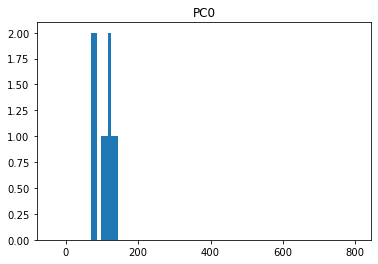

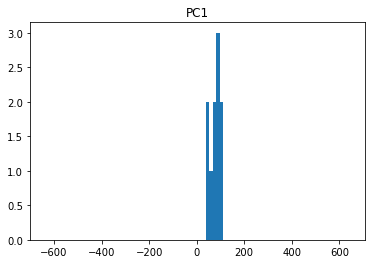

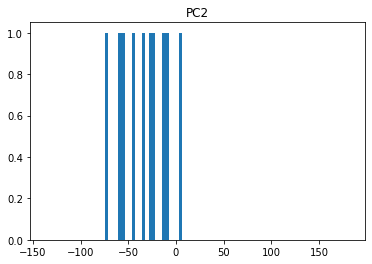

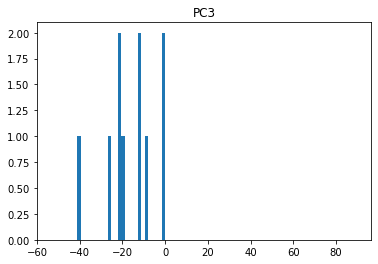

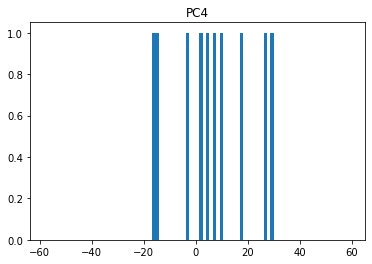

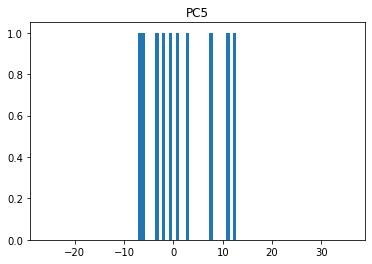

In [34]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 100))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)   

In [35]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 16.007362667465156
Scatter median: 16.43340240611628
Scatter std: 5.912085043072648
Scatter max: 23.47729182862286
Scatter min: 6.402560467325652


In [36]:
ref_name_l, id_l, dist_l = [], [], []
for ref in list(dataset_bank.index):
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')
ann_dist_all_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,dist=0,dist=1,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9
key_0,,,,,,,,,,,,,,,,,,,,
2019lbi,0,96,240,465,296,326,70,90,337,486,0.0,80.216873,97.707169,106.133827,119.626030,126.489479,129.903946,134.355545,137.773575,144.417694
2019pmd,1,382,2,422,95,448,94,438,81,303,0.0,46.877266,47.078033,50.280861,51.951317,52.831615,54.728233,55.207756,59.382420,59.816151
2019tvv,2,95,1,382,94,303,9,438,260,422,0.0,45.935852,47.078033,49.598923,56.382187,63.682781,65.051483,75.519371,78.548714,78.561096
2019ucc,3,319,459,670,650,106,51,252,454,41,0.0,21.861115,24.618073,31.493504,31.562330,32.460991,33.850796,34.454754,34.988419,35.214859
2019uev,4,442,341,64,645,431,108,300,311,72,0.0,20.252827,26.982574,27.259682,27.833424,30.399303,30.535364,33.126656,33.331017,33.633099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021zcj,699,163,570,52,159,428,161,471,390,154,0.0,10.286498,12.030469,14.800612,16.711849,17.292202,17.355383,18.070551,18.644028,18.834564
2021zep,700,457,594,497,583,63,684,592,446,622,0.0,11.043327,25.252851,26.419538,27.050306,27.815149,27.858988,28.645140,29.308002,29.776899
2021zri,701,63,644,592,252,327,266,549,136,394,0.0,20.109650,22.254036,24.598881,27.893303,28.919004,29.031876,31.016697,31.535299,31.648170


In [37]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df['dist=1']))
print("Scatter median:", np.median(ann_dist_all_df['dist=1']))
print("Scatter std:", np.std(ann_dist_all_df['dist=1']))
print("Scatter max:", np.max(ann_dist_all_df['dist=1']))
print("Scatter min:", np.min(ann_dist_all_df['dist=1']))
print("\n")


# Returns index of max distance
print("Most anomalous (max distance of ref to ANN=1):", ann_dist_all_df[['dist=1']].idxmax().values[0])

summary stats
Scatter mean: 18.48353607749397
Scatter median: 12.832775592803955
Scatter std: 23.38047910300999
Scatter max: 399.7420959472656
Scatter min: 3.568307876586914


Most anomalous (max distance of ref to ANN=1): 2020nov


In [38]:
ref_obj = '2020nov'
print("Dist=1:", ann_dist_all_df.loc[ref_obj]['dist=1']) # Kron, Ap, and PSF fluxes are too high

Dist=1: 399.7420959472656


In [39]:
dataset_bank[dataset_bank.index == ref_obj]

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2020nov,714.711162,707.846931,-102.776069,42.257897,-27.828194,-23.371389


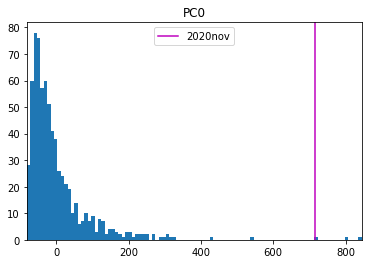

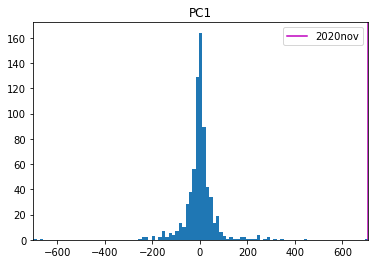

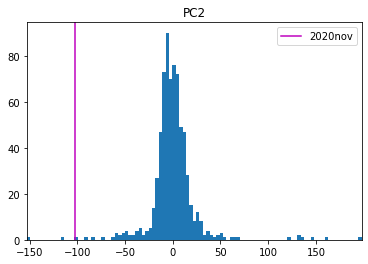

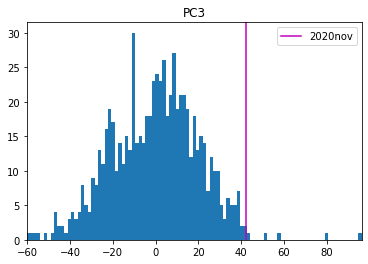

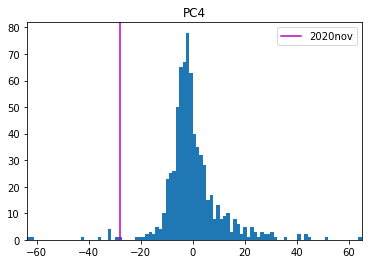

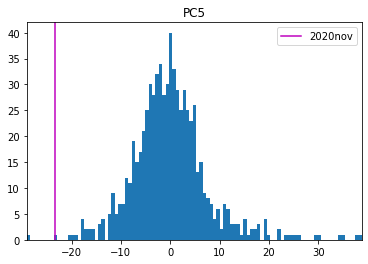

In [40]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [41]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[714.7111618654641 707.8469314057083 -102.77606927063633 42.25789736938874
 -27.828194297119367 -23.371389286902602]
ZTF ID name (ref) 2020nov


https://ziggy.ucolick.org/yse/transient_detail/2020nov

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2020nov

0		220				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2020ghq

1		111				None			399.7421


https://ziggy.ucolick.org/yse/transient_detail/2020kre

2		185				None			547.8502


https://ziggy.ucolick.org/yse/transient_detail/2020opy

3		231				None			548.3911


https://ziggy.ucolick.org/yse/transient_detail/2020sgf

4		299				None			568.0322


https://ziggy.ucolick.org/yse/transient_detail/2020ciu

5		90				None			600.8287


https://ziggy.ucolick.org/yse/transient_detail/2020tlf

6		326				None			663.8442


https://ziggy.ucolick.org/yse/transient_detail/2020eaf

7		96				None			672.1417


https://ziggy.ucolick.org/yse/transient_detail/2020svn

8		310				None			685.856


https://ziggy.ucolick.org/yse/transient_detail/2020sck

9		296				None			690.7039


In [42]:
# 10 largest ANN=1 distances
ann_dist_all_df['dist=1'].nlargest(10)

key_0
2020nov     399.742096
2020sgf     280.085510
2020ghq     154.462234
2021hiz     104.949631
2021qzi     104.949631
2020pni      93.347412
2020abim     91.532478
2019lbi      80.216873
2021dov      77.172577
2020ovk      74.233978
Name: dist=1, dtype: float64

# all weird!

2020nov    399.742096 # TDE
2020sgf    280.085510 # Very red Ic
2020ghq    154.462234 # 2 SN in same position
2021hiz    104.949631 # very bright Ia (app mag ~ 13), z=0.003319 in Virgo
2021qzi    104.949631 # SN II in spiral, z=0.027365; looks kinda normal
2020pni      93.347412 # Flash ionization, SN II, z=0.01687, bright (app mag ~ 16)
2020abim     91.532478 # Ia on decline (only blue part of light curve), z=0.015
2019lbi      80.216873 # gap of like 100d, SN II, z=0.013
2021dov      77.172577 # SN Ia, z=0.012, bright (app mag ~ 15)
2020ovk      74.233978 # Well sampled SN II, z=0.025

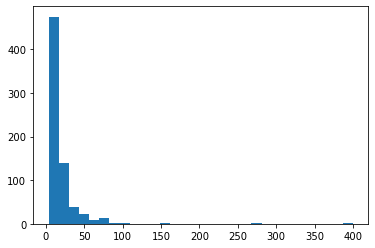

In [43]:
plt.hist(ann_dist_all_df['dist=1'], 
         bins=np.linspace(np.min(ann_dist_all_df['dist=1']), 
                          np.max(ann_dist_all_df['dist=1']), 31));

In [44]:
# 10 smallest ANN=1 distances (most similar)
ann_dist_all_df['dist=1'].nsmallest(10)

key_0
2020rvg     3.568308
2021lru     3.568308
2020aahq    4.128008
2021kpr     4.128008
2020tzs     4.148623
2021xbn     4.148623
2021dpj     4.302462
2021fom     4.302462
2021adnv    4.340722
2021pca     4.340722
Name: dist=1, dtype: float64

2020rvg     3.568308 # Looks damn similar! LC and host and z
2021lru     3.568308 # Looks damn similar^! LC and host and z
2020aahq    4.128008 # Fairly similar
2021kpr     4.128008 # Fairly similar
2020tzs     4.148623 # Fairly similar
2021xbn     4.148623 # Fairly similar
2021dpj     4.302462 # Looks damn similar^! LC and host
2021fom     4.302462 # Looks damn similar^! LC and host
2021adnv    4.340722 # Looks damn similar^! LC and host and z
2021pca     4.340722 # Looks damn similar^! LC and host and z

In [45]:
dataset_ref = dataset_bank[dataset_bank.index == '2020rvg']

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[-78.71864853857467 -5.587625667054386 -7.300062085286417
 21.420488794652016 -0.3938627790332009 -0.12663931368743095]
ZTF ID name (ref) 2020rvg


https://ziggy.ucolick.org/yse/transient_detail/2020rvg

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2020rvg

0		291				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2021lru

1		562				None			3.5683


https://ziggy.ucolick.org/yse/transient_detail/2021scq

2		628				None			8.7124


https://ziggy.ucolick.org/yse/transient_detail/2020kns

3		180				None			9.3161


https://ziggy.ucolick.org/yse/transient_detail/2020yiy

4		374				None			9.7146


https://ziggy.ucolick.org/yse/transient_detail/2021iig

5		511				None			9.7198


https://ziggy.ucolick.org/yse/transient_detail/2020tri

6		329				None			9.7382


https://ziggy.ucolick.org/yse/transient_detail/2020rfx

7		274				None			10.8456


https://ziggy.ucolick.org/yse/transient_detail/2020rok

8		282				None			11.6079


https://ziggy.ucolick.org/yse/transient_detail/2020alx

9		76				None			12.4482


# TODO: what about known weird ones? i.e. 2020acct



In [46]:
dataset_ref = dataset_bank[dataset_bank.index == '2020acct']

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[35.514867911226695 29.865931005866358 -9.166447509493826
 -37.413701481493725 -9.092349030504689 37.47896055507094]
ZTF ID name (ref) 2020acct


https://ziggy.ucolick.org/yse/transient_detail/2020acct

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2020acct

0		46				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2020zpi

1		388				None			30.2687


https://ziggy.ucolick.org/yse/transient_detail/2021pj

2		603				None			30.9366


https://ziggy.ucolick.org/yse/transient_detail/2021zri

3		701				None			41.9079


https://ziggy.ucolick.org/yse/transient_detail/2020tly

4		327				None			47.2031


https://ziggy.ucolick.org/yse/transient_detail/2021wue

5		675				None			48.7025


https://ziggy.ucolick.org/yse/transient_detail/2021bwv

6		442				None			51.8237


https://ziggy.ucolick.org/yse/transient_detail/2020mks

7		203				None			51.9237


https://ziggy.ucolick.org/yse/transient_detail/2021pci

8		597				None			54.6357


https://ziggy.ucolick.org/yse/transient_detail/2021tks

9		644				None			55.6554


https://ziggy.ucolick.org/yse/transient_detail/2020acct/
https://ziggy.ucolick.org/yse/transient_detail/2020zpi/

#### Host environments v similar (spiral, z~0.035), kinda similar LCs (17-18 mag), similar timescales
#### More host similarities than lc similarities (think about for weighting features and selection)

In [47]:
dataset_ref = dataset_bank[dataset_bank.index == '2020neh']
dataset_ref

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2020neh,-21.574346,42.783114,-13.635367,0.562073,20.145384,-0.889649


In [48]:
dataset_ref = dataset_bank[dataset_bank.index == '2020neh']

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[-21.574345957955288 42.78311370448053 -13.635367160978605
 0.5620725235509366 20.145384133666546 -0.8896485147985308]
ZTF ID name (ref) 2020neh


https://ziggy.ucolick.org/yse/transient_detail/2020neh

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2020neh

0		214				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2019wmr

1		8				None			22.8742


https://ziggy.ucolick.org/yse/transient_detail/2021lnv

2		559				None			23.5507


https://ziggy.ucolick.org/yse/transient_detail/2021bpq

3		437				None			23.9482


https://ziggy.ucolick.org/yse/transient_detail/2021fwm

4		478				None			24.0785


https://ziggy.ucolick.org/yse/transient_detail/2021joz

5		529				None			24.6082


https://ziggy.ucolick.org/yse/transient_detail/2020kmj

6		178				None			25.7702


https://ziggy.ucolick.org/yse/transient_detail/2020lgy

7		192				None			27.3504


https://ziggy.ucolick.org/yse/transient_detail/2021vaw

8		663				None			27.7838


https://ziggy.ucolick.org/yse/transient_detail/2021arg

9		428				None			28.2652


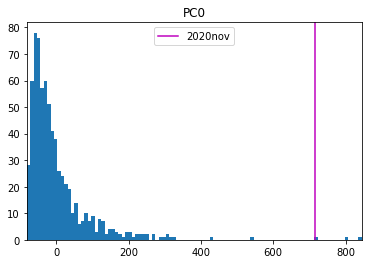

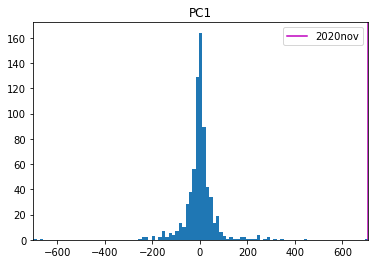

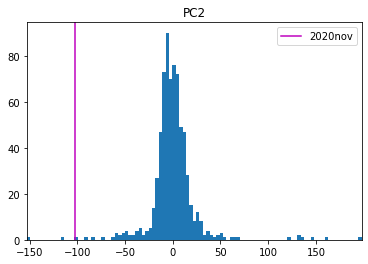

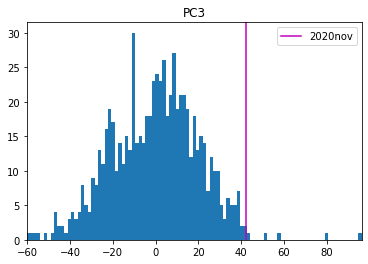

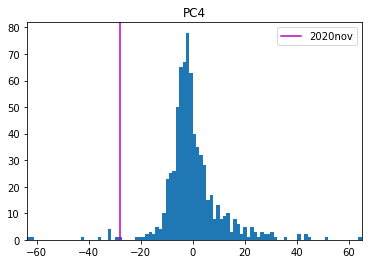

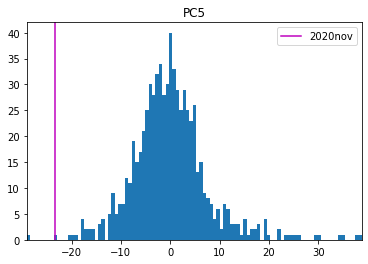

In [56]:
ref_obj = '2020nov'
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

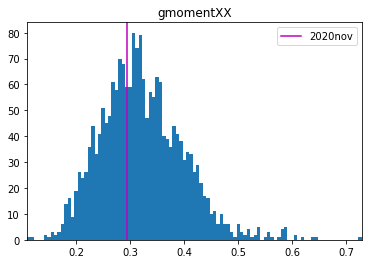

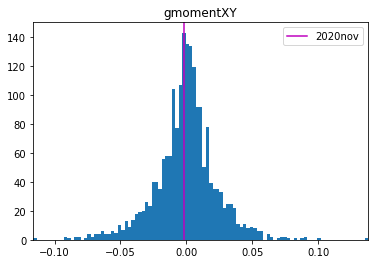

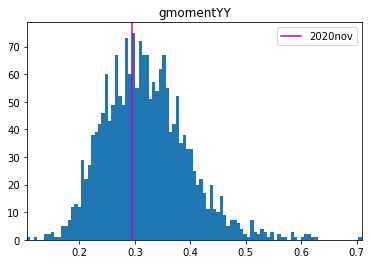

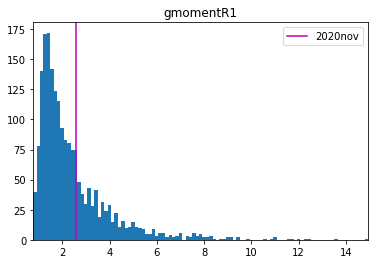

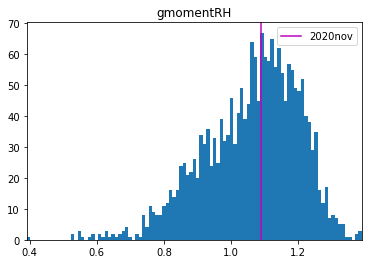

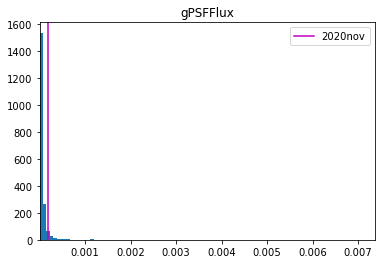

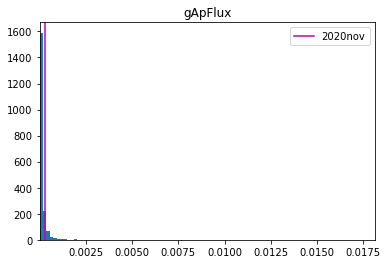

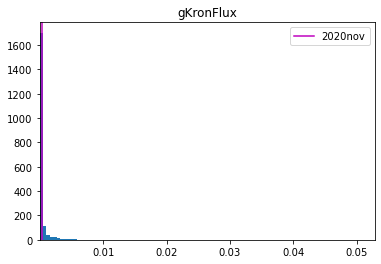

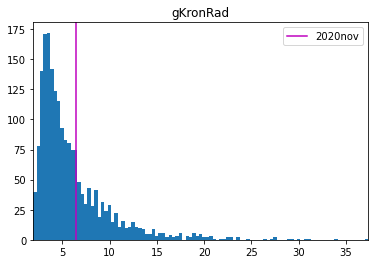

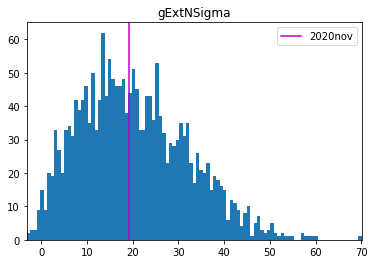

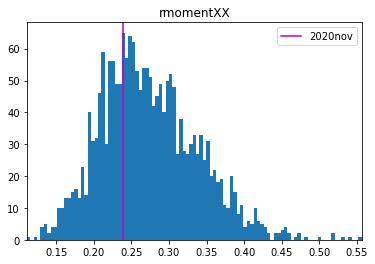

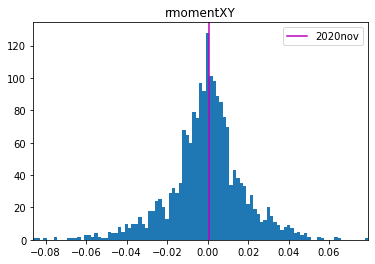

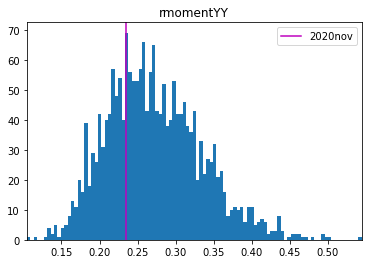

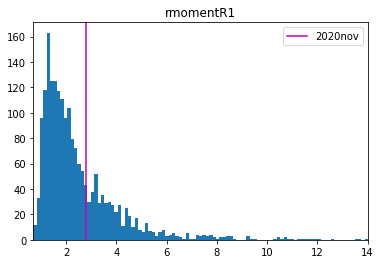

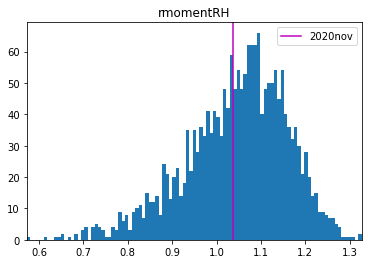

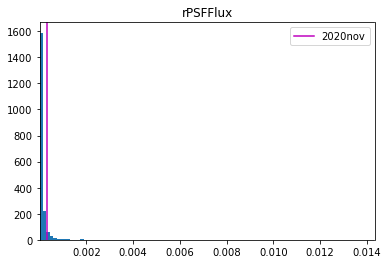

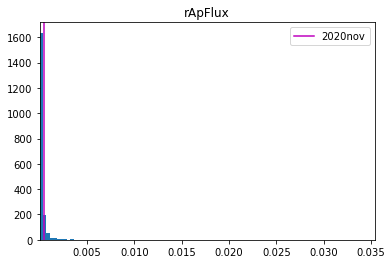

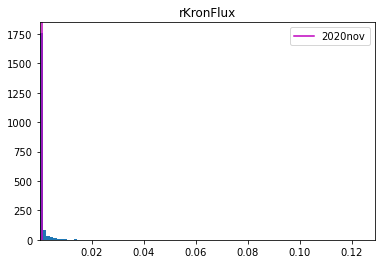

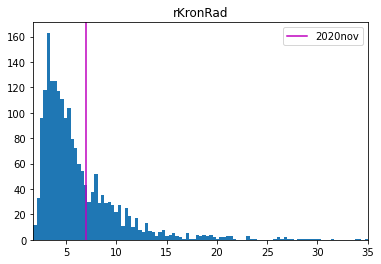

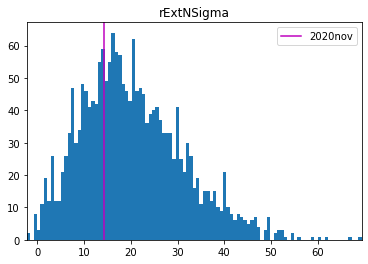

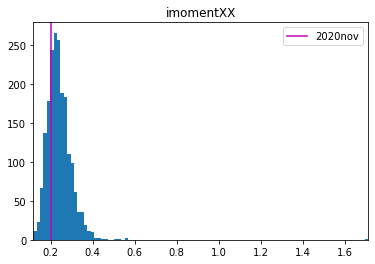

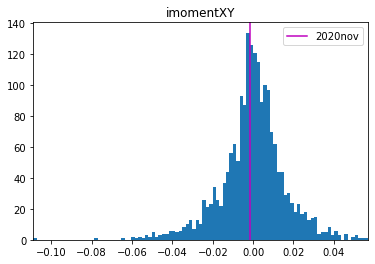

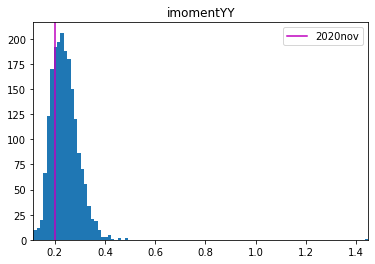

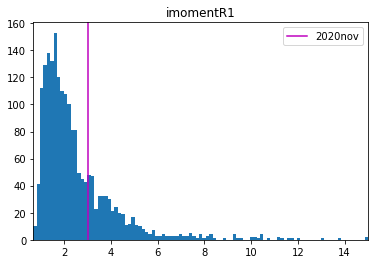

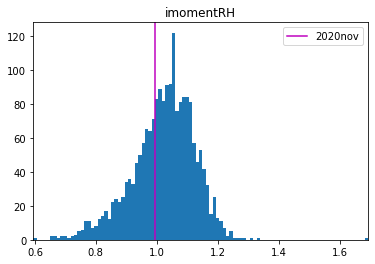

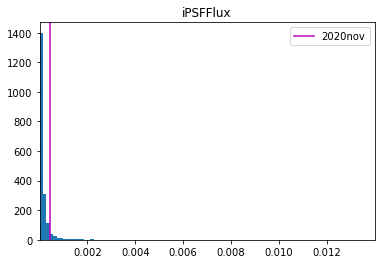

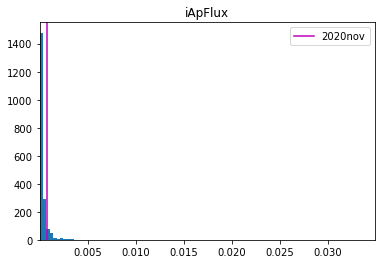

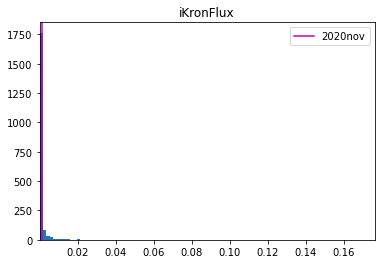

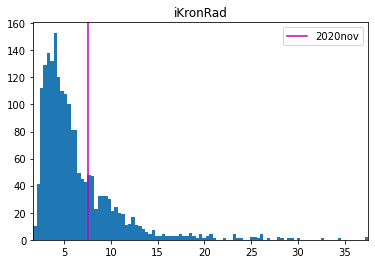

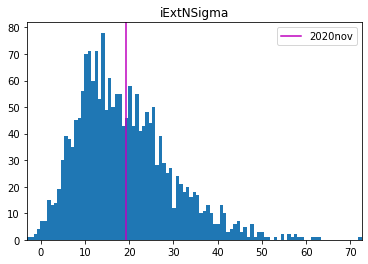

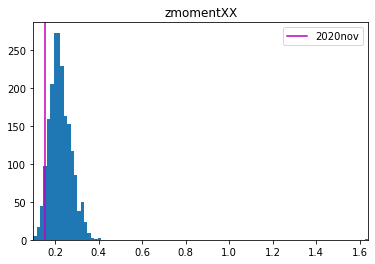

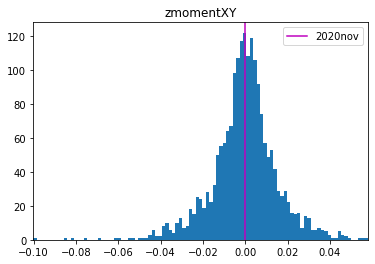

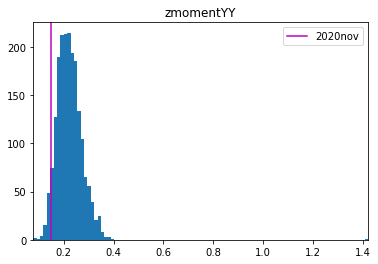

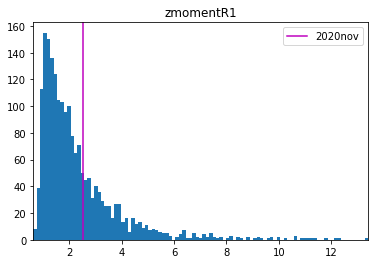

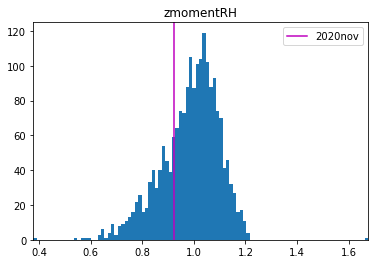

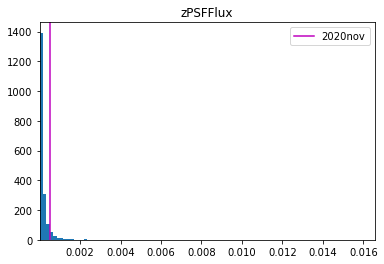

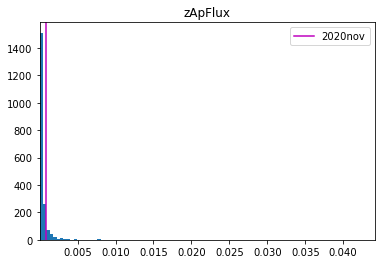

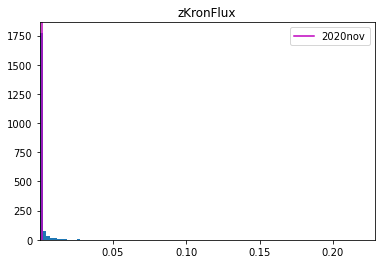

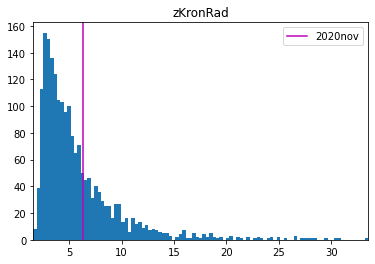

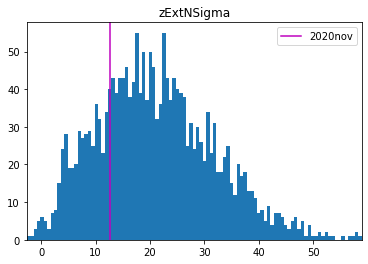

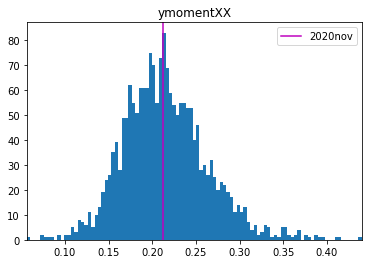

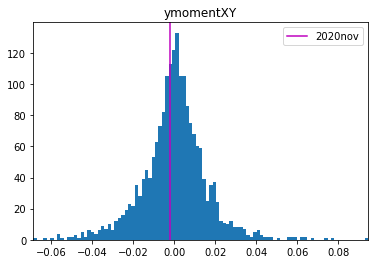

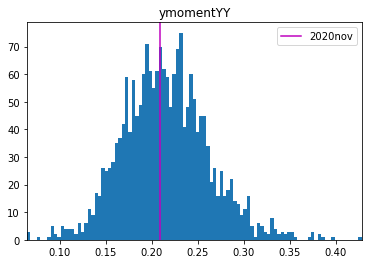

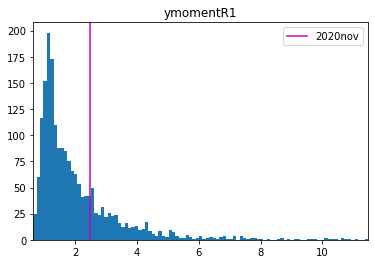

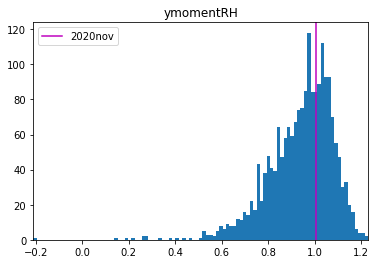

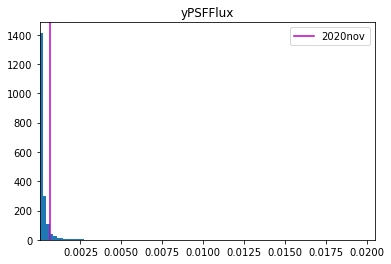

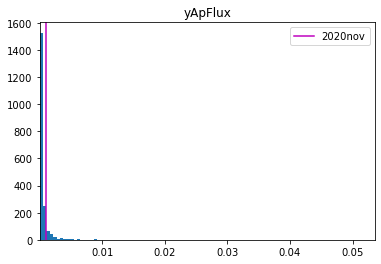

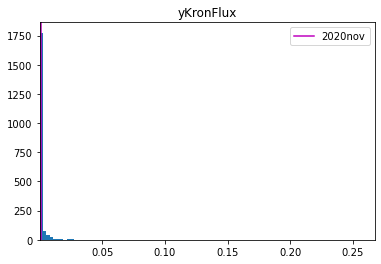

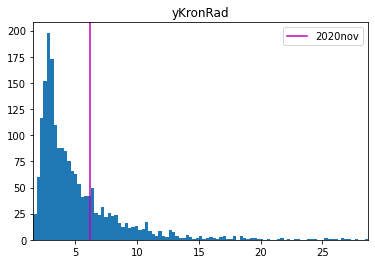

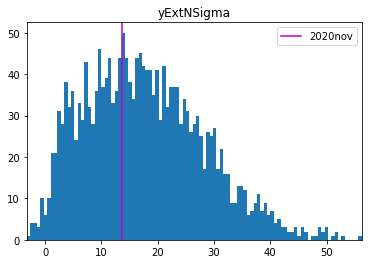

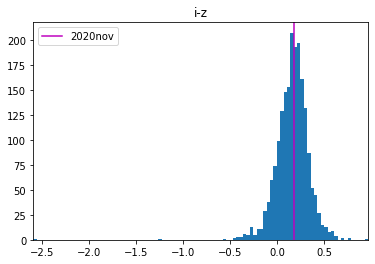

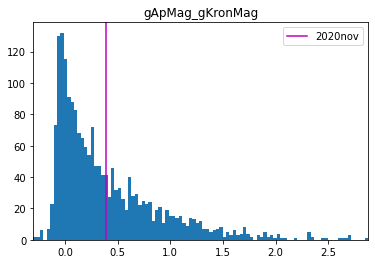

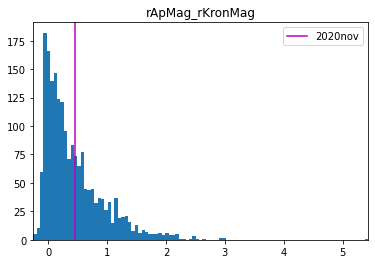

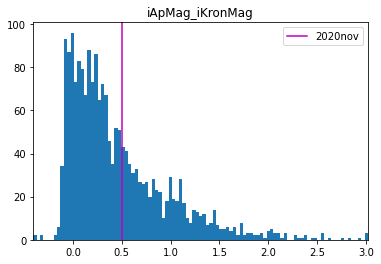

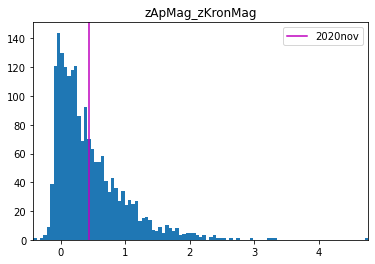

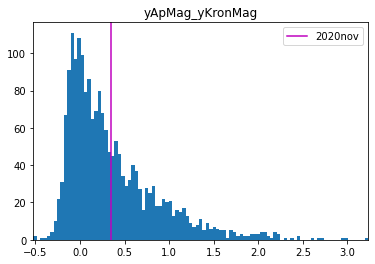

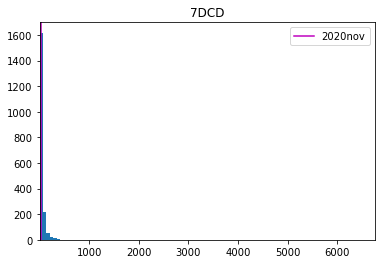

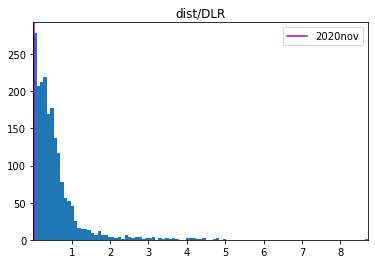

In [57]:
feat_scatter_l = []
for feat in host_dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(host_dataset_bank[feat]), np.max(host_dataset_bank[feat])
    
    ax.hist(host_dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = host_dataset_bank[host_dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(host_dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

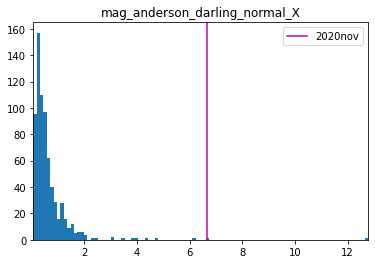

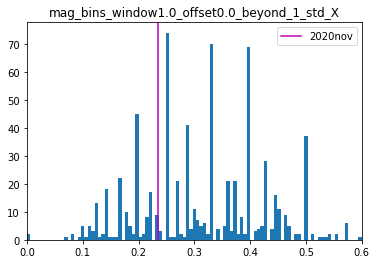

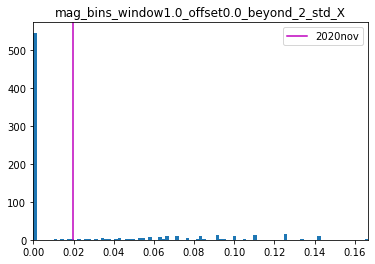

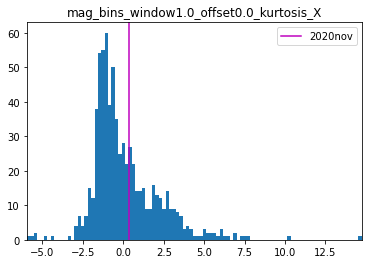

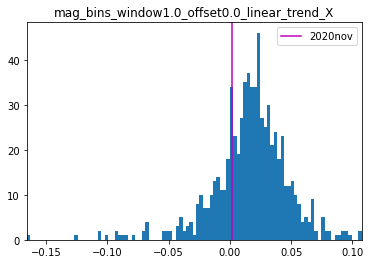

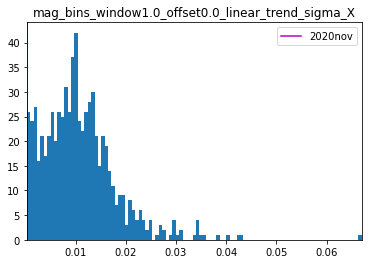

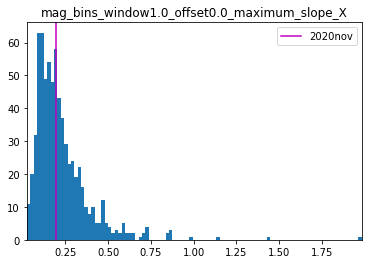

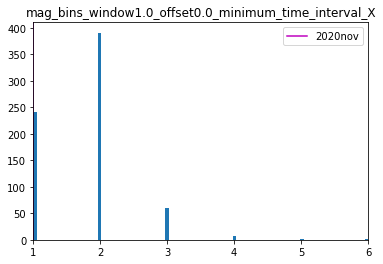

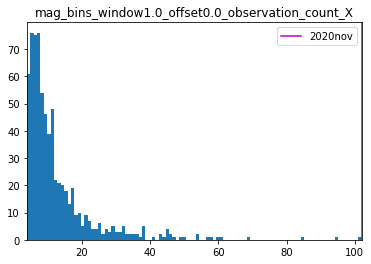

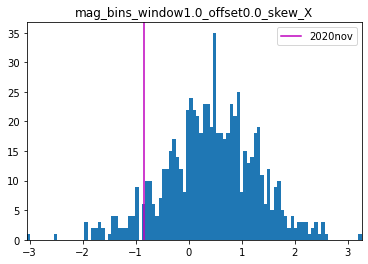

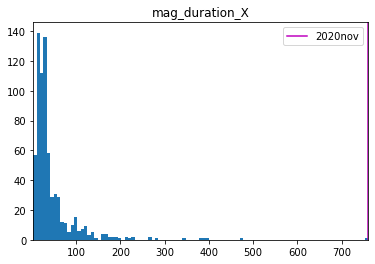

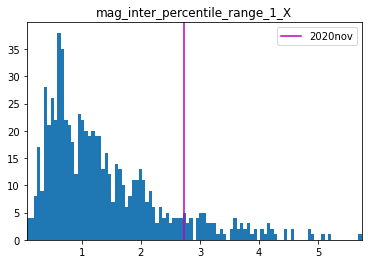

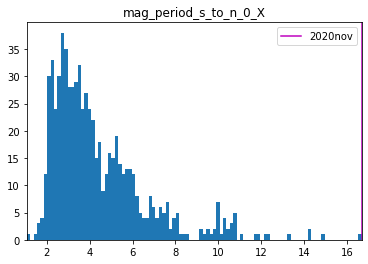

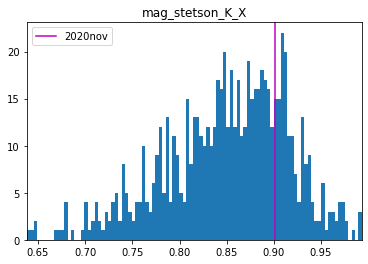

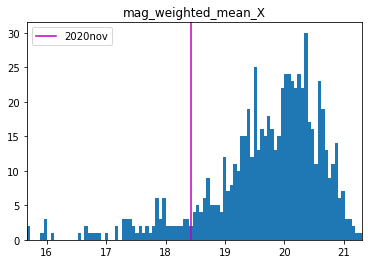

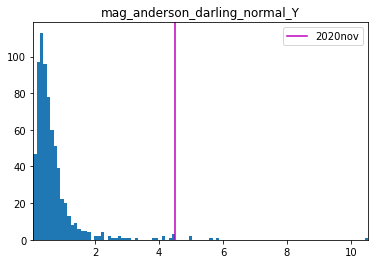

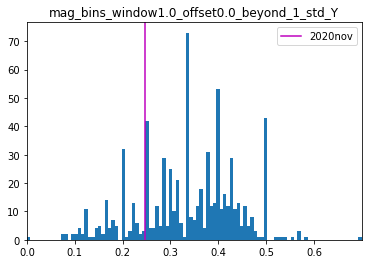

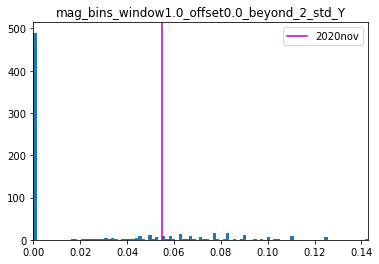

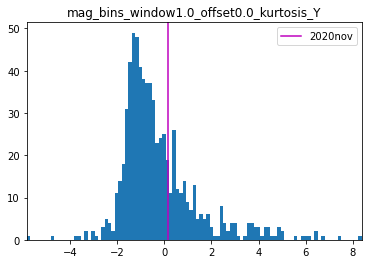

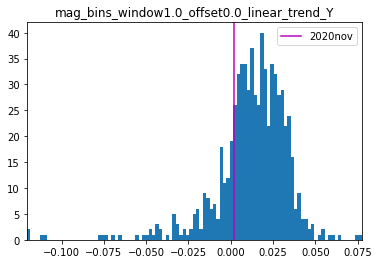

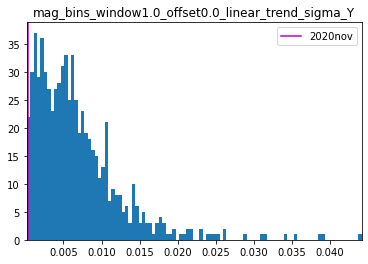

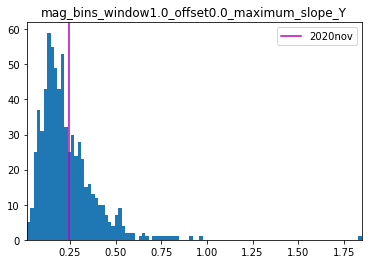

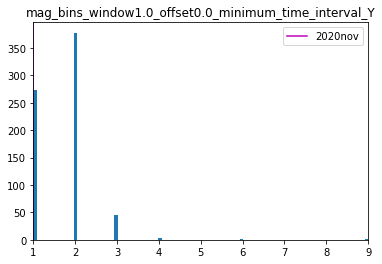

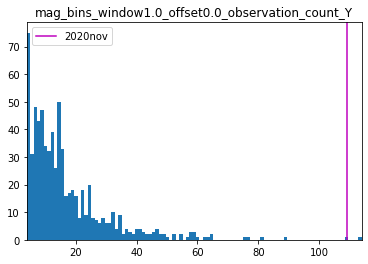

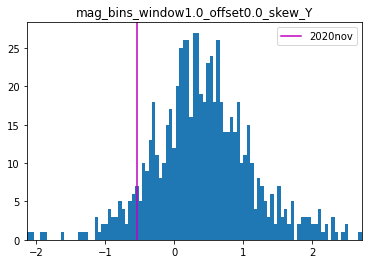

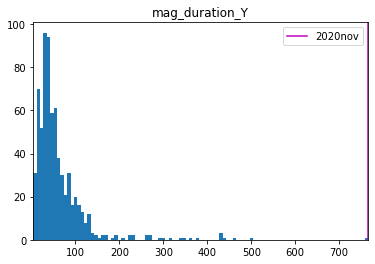

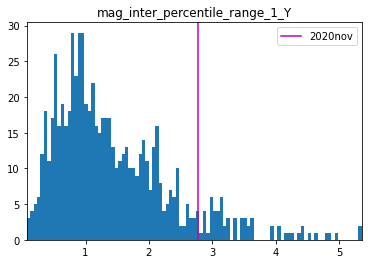

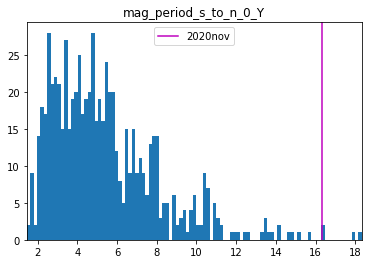

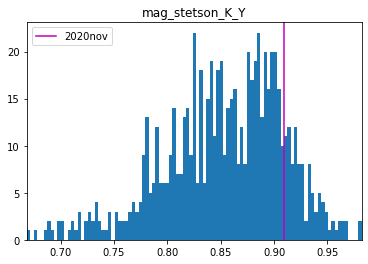

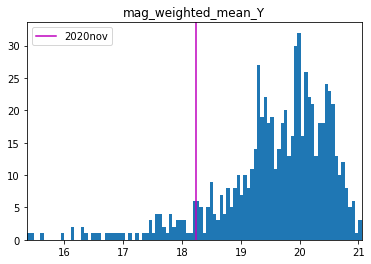

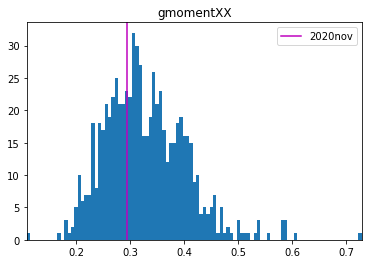

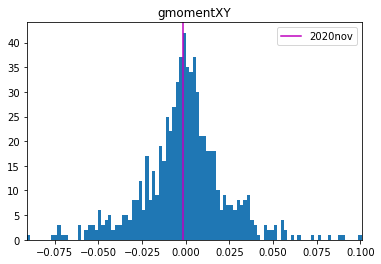

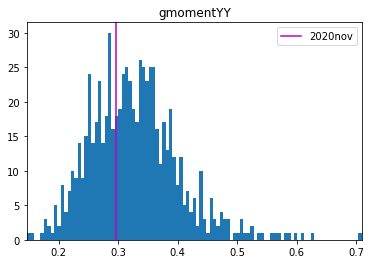

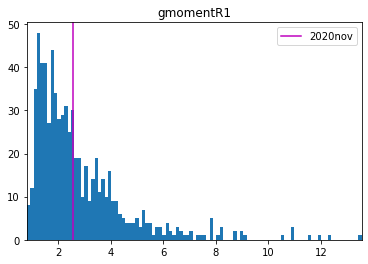

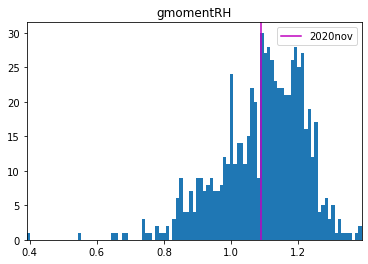

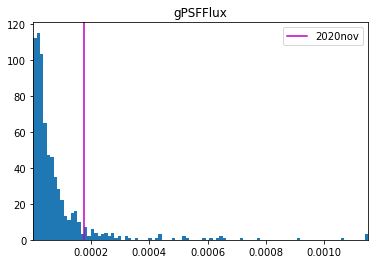

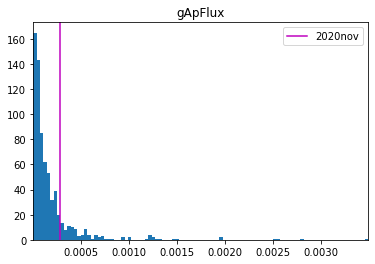

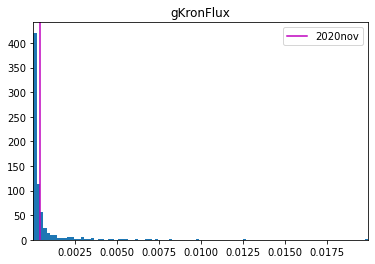

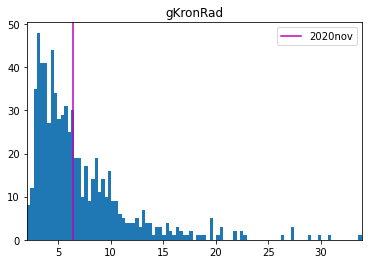

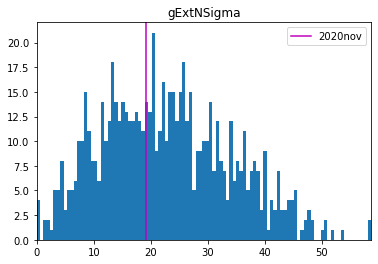

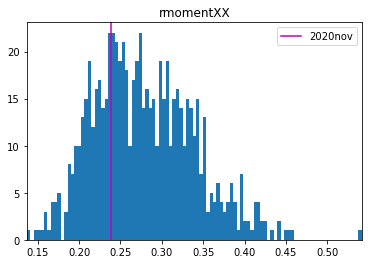

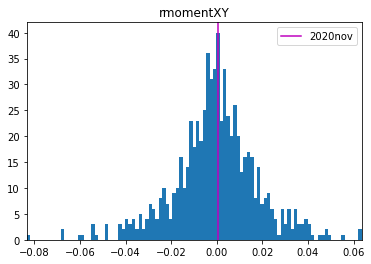

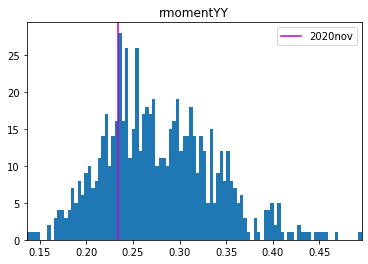

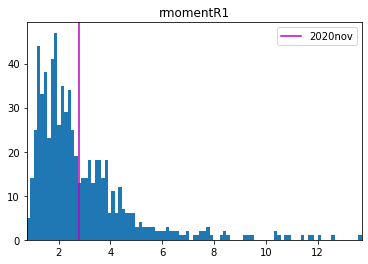

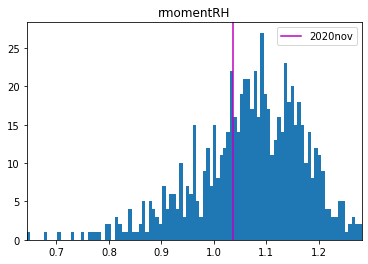

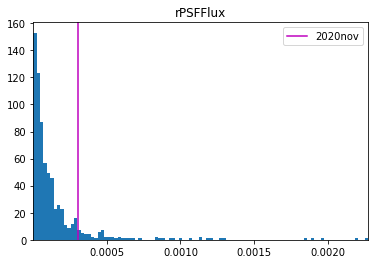

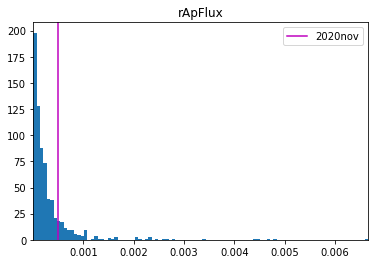

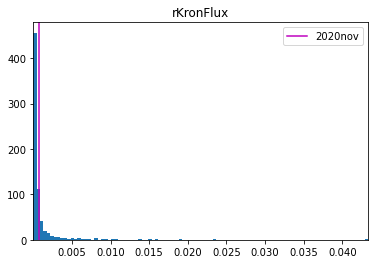

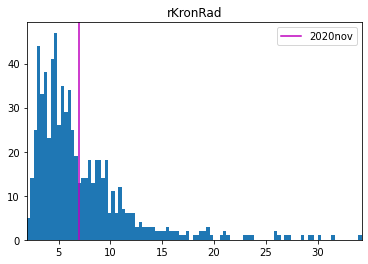

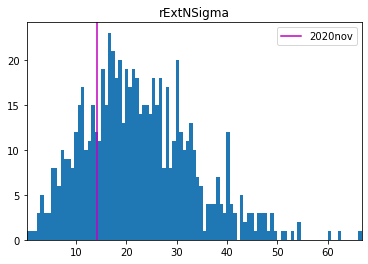

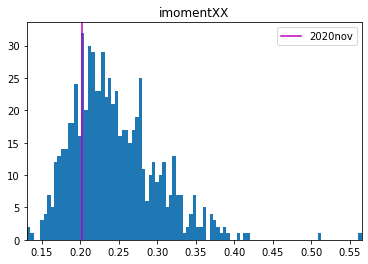

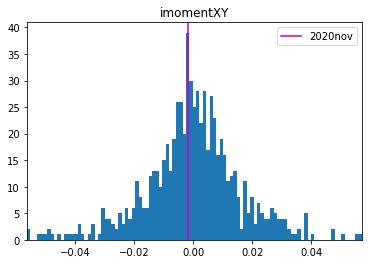

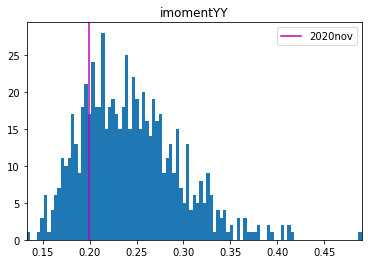

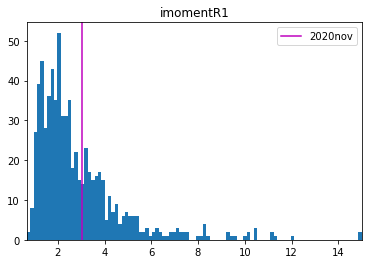

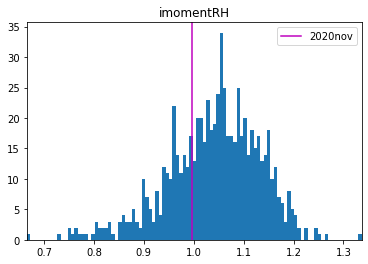

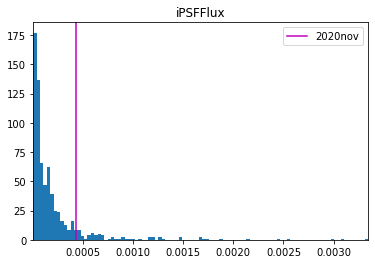

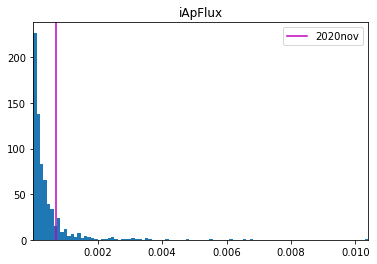

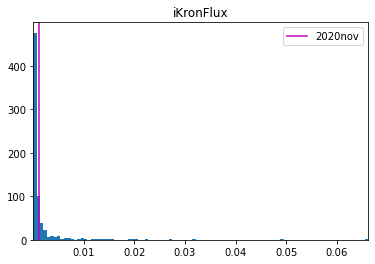

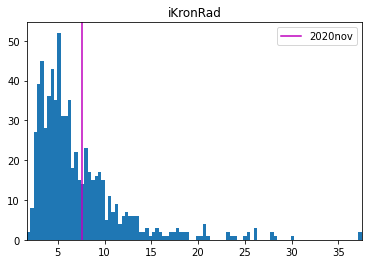

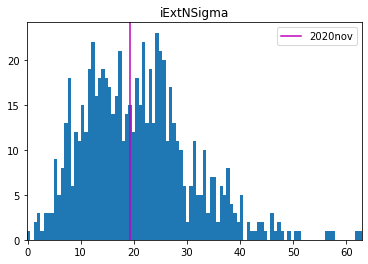

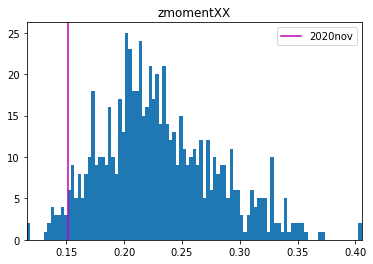

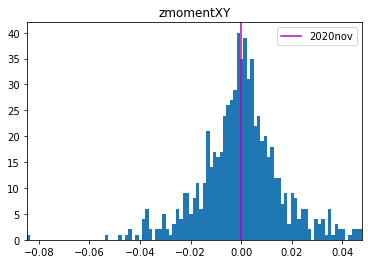

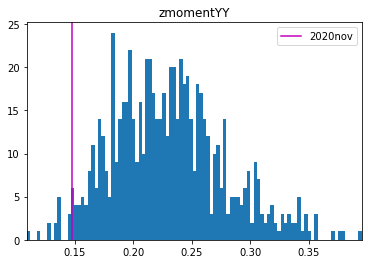

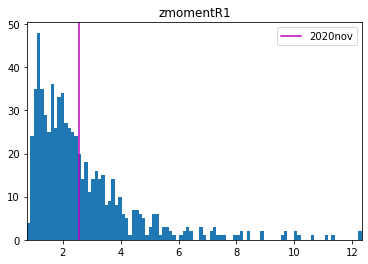

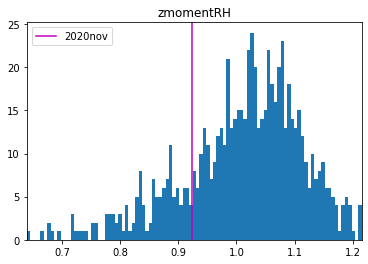

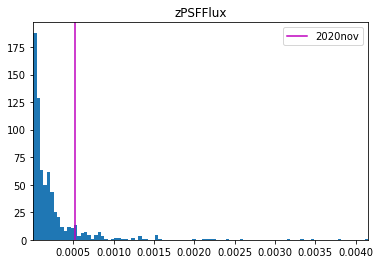

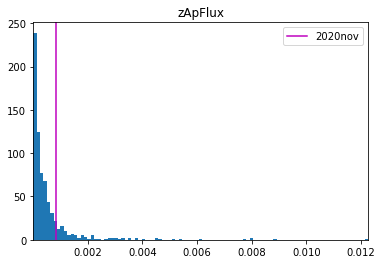

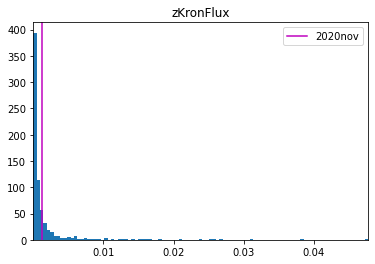

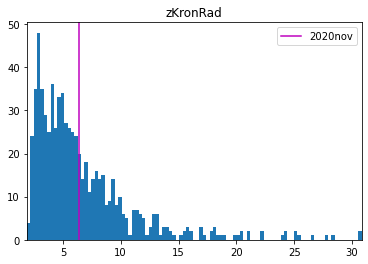

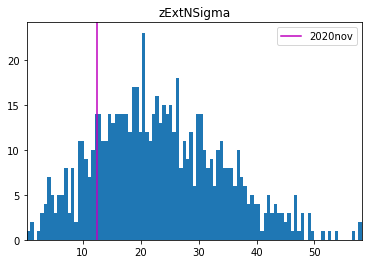

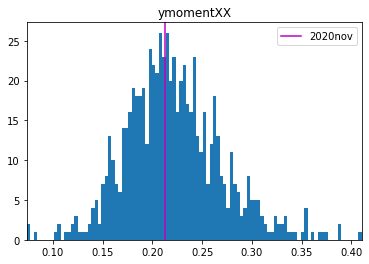

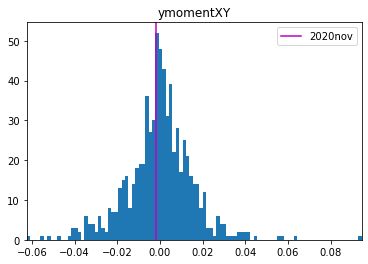

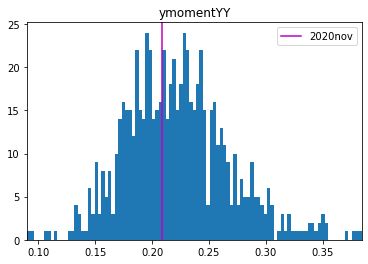

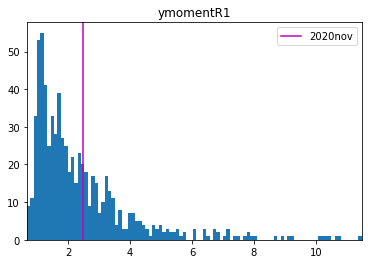

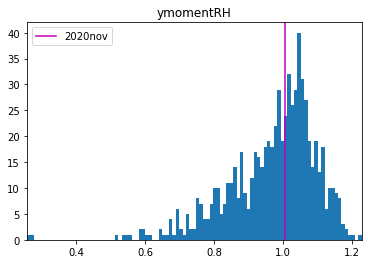

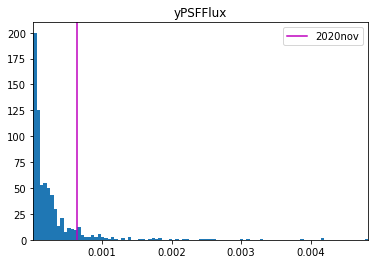

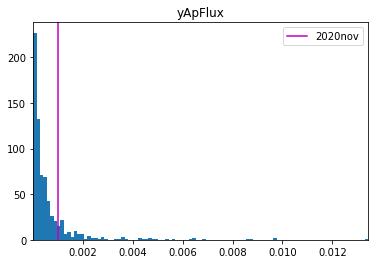

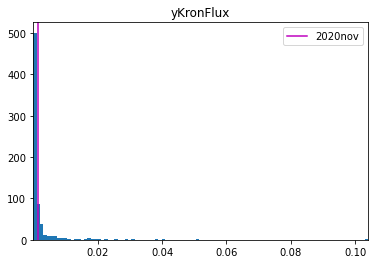

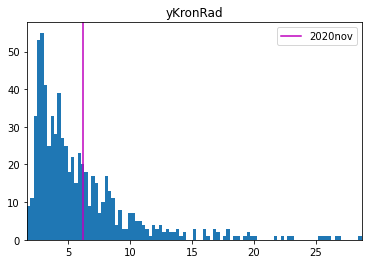

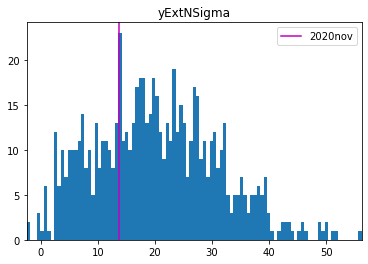

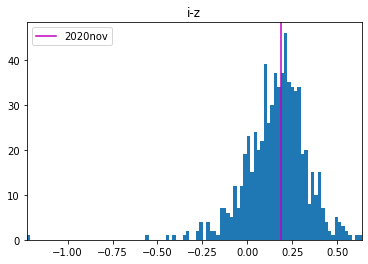

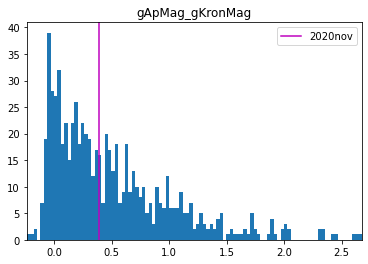

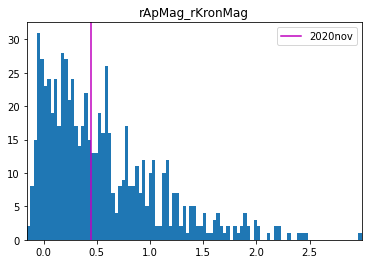

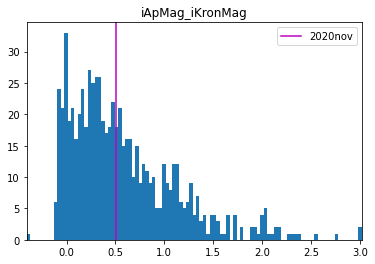

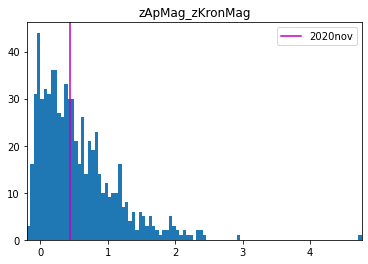

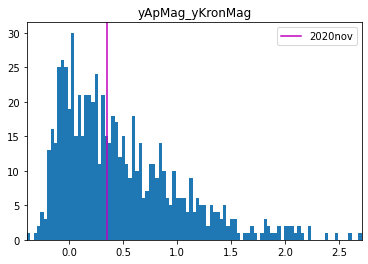

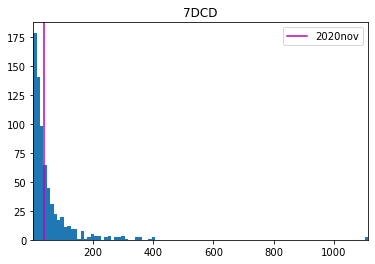

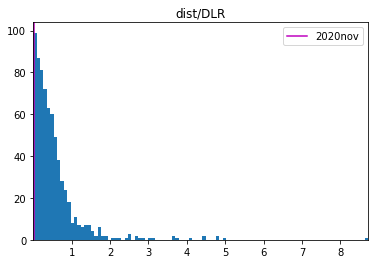

In [65]:
feat_scatter_l = []
for feat in dataset_bank_orig.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank_orig[feat]), np.max(dataset_bank_orig[feat])
    
    ax.hist(dataset_bank_orig[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank_orig[dataset_bank_orig.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank_orig[feat])
    feat_scatter_l.append(feat_scatter)   

In [60]:
dataset_bank_orig.loc['2020nov']['mag_bins_window1.0_offset0.0_linear_trend_sigma_X']

0.0003220806538593024

In [55]:
dataset_bank_orig.columns.to_list()

['mag_anderson_darling_normal_X',
 'mag_bins_window1.0_offset0.0_beyond_1_std_X',
 'mag_bins_window1.0_offset0.0_beyond_2_std_X',
 'mag_bins_window1.0_offset0.0_kurtosis_X',
 'mag_bins_window1.0_offset0.0_linear_trend_X',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_X',
 'mag_bins_window1.0_offset0.0_maximum_slope_X',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_X',
 'mag_bins_window1.0_offset0.0_observation_count_X',
 'mag_bins_window1.0_offset0.0_skew_X',
 'mag_duration_X',
 'mag_inter_percentile_range_1_X',
 'mag_period_s_to_n_0_X',
 'mag_stetson_K_X',
 'mag_weighted_mean_X',
 'mag_anderson_darling_normal_Y',
 'mag_bins_window1.0_offset0.0_beyond_1_std_Y',
 'mag_bins_window1.0_offset0.0_beyond_2_std_Y',
 'mag_bins_window1.0_offset0.0_kurtosis_Y',
 'mag_bins_window1.0_offset0.0_linear_trend_Y',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_Y',
 'mag_bins_window1.0_offset0.0_maximum_slope_Y',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_Y',
 'mag_bins_window1.

# kinda ish center on host (again, host is taking preference)
# 30 LC features, 58 host features
# ~ 2:1 host:LC feature ratio...maybe more balance?

# TODO: Need more balance of LC features with host?
# More weight on lc features? Maybe vice versa?